# Prototyping intertidal exposure mapping workflow

- Import NIDEM
- Import OTPS
- For area of interest, calculate median time of exposure 
    between inundations from OTPS modelling for the period of data included into the NIDEM workflow
- Build values back into the NIDEM xarray
- Save as a raster



# Exposure mapping approach 1
## Timestep mapping
Approach after Choi et al., 2016 exposure mapping based on ITEM in QLD

Method:
- Tidal model run for aoi at 10 minute intervals for x period of time (Ensure it captures at least 1 full tidal cycle - preferably at least a month or longer)
- Starting with an xarray (ds) for the aoi containing NIDEM:
    - add new ds variable for each modelled timestep, masking the modelled tideheight against NIDEM  (pixels below modelled tideheight were masked out)
    - run a pixel drill through modelled timesteps to determine how many observations are returned as dry as a percentage of all observations for that pixel (this is the exposure calculation)
    - map the exposure for the aoi as a percentage of total (modelled) time
    - threshold the exposure ranges against NIDEM height

To do: 
- Look for some validation data
- Try again in Moreton Bay
- Consider the spatial frequency to run the tidal model
- Consider the temporal frequency to run the tidal model (time series and modelling frequency e.g. 1 month with 10 minute intervals)
- Consider other approaches incl my original plan for calculating daily or event exposure (e.g. average 2 hours exposure between tides).
    - Requires modelling the tidal curve (tricky! But perhaps a linear calculation between adjacent modelled tideheights might work. Similarly, reducing the accuracy (decimal places) of the modelled results and NIDEM might also improve modelling outputs)
    - Calculating individual exposure periods over x period of time and determining median time of exposure between successive tides

### Import modules

In [1]:
import datacube
from odc.ui import with_ui_cbk
import sys

sys.path.append("../Scripts")
from dea_plotting import display_map
# from otps import TimePoint
# from otps import predict_tide
# import otps
from dea_coastaltools import tidal_tag
from dea_coastaltools import tidal_stats
from dea_dask import create_local_dask_cluster

# Import required packages
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from otps import TimePoint
from otps import predict_tide
from datacube.utils.geometry import CRS

# Fix converters for tidal plot
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
dc = datacube.Datacube(app="intertidal_exposure")
create_local_dask_cluster()

/env/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41349 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:33927 Dashboard: /user/cp/proxy/41349/status,Cluster Workers: 1 Cores: 7 Memory: 63.57 GB


### Query and display map

In [3]:
# Designate dask chunks
# It doesn't really matter how big the chunks we load are, as long as time ~ 1.
chunks = {"time": 1, "x": 1000, "y": 1000}

#set up our inputs to collect_training_data
products =  ['nidem']
time = ('1986', '2018')
# x = (x1, x2)
# y = (y1, y2)

## Toondah Harbour, QLD
x=(153.16984, 153.44664)
y=(-27.43959, -27.71674)
# Lat / Lon 
# 27.43959°S, 153.16984°E
# Lat / Lon 
# 27.71674°S, 153.44664°

## Southern Gladstone region, QLD
# x=(151.39537811278885, 151.96872711181226)
# y=(-23.920677965781103, -24.241642828863014)

# lon	151.39537811278885
# lat	-23.920677965781103

# lon	151.96872711181226
# lat	-24.241642828863014


# reduce_func = None
# calc_indices = ['NDVI','MNDWI']
# drop = False
# zonal_stats = 'median'
# return_coords = True

# Set up the inputs for the ODC query
measurements =  ['nidem']
resolution = (-30,30)
output_crs='epsg:3577'

query = {
#     'product': products,
    'x': x,
    'y': y,
    "dask_chunks": chunks
#     'time': time,
#     'measurements': measurements,
#     'resolution': resolution,
#     'output_crs': output_crs,
#     'group_by' : 'solar_day',
}

# Plot training data in an interactive map
display_map(x=x, y=y)

### Set the tidepost for tidal modelling

In [4]:
## Toondah Harbour QLD 
tp_x = 153.31303
tp_y = -27.47065

# ## Southern Gladstone region QLD
# tp_x = 151.5934
# tp_y = -24.0299

x1=(tp_x, tp_x)
y1=(tp_y, tp_y)

display_map(x=x1, y=y1)

### Load NIDEM

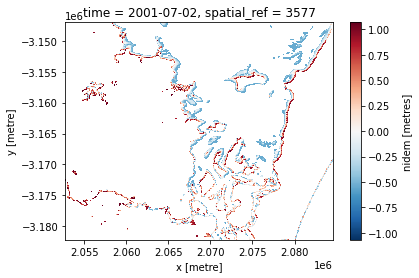

In [5]:
ds = dc.load(product='nidem',
#              x=x,
#              y=y,
#              "dask_chunks": chunks
              **query
#             x=(153.3, 153.4),
#             y=(-27.5, -27.6)
#             time=('1986','2018')
            )
# print(ds)

ds = ds.where(ds.nidem > ds.nidem.min())

ds.nidem.plot()

### Tidal modelling
Pulling tidal modelling for a given location code out of dea_coastaltools.py script

In [6]:
def tidal_stats(
#                 ds, 
                start='1/1/1988',
                end='1/1/2019',
                tidepost_lat=None,
                tidepost_lon=None,
                plain_english=True, 
                plot=True,
                modelled_freq='10min',
                round_stats=3): 
    """
    Takes an xarray.Dataset and statistically compares the tides 
    modelled for each satellite observation against the full modelled 
    tidal range. This comparison can be used to evaluate whether the 
    tides observed by satellites (e.g. Landsat) are biased compared to 
    the natural tidal range (e.g. fail to observe either the highest or 
    lowest tides etc).    
       
    By default, the function models tides for the centroid of the 
    dataset, but a custom tidal modelling location can be specified 
    using `tidepost_lat` and `tidepost_lon`.
    
    Tides are modelled using the OTPS tidal modelling software based on
    the TPXO8 tidal model: http://volkov.oce.orst.edu/tides/tpxo8_atlas.html
    
    For more information about the tidal statistics computed by this 
    function, refer to Figure 8 in Bishop-Taylor et al. 2018:
    https://www.sciencedirect.com/science/article/pii/S0272771418308783#fig8
    
    Parameters
    ----------     
    ds : xarray.Dataset
        An xarray.Dataset object with x, y and time dimensions  
    tidepost_lat, tidepost_lon : float or int, optional
        Optional coordinates used to model tides. The default is None,
        which uses the centroid of the dataset as the tide modelling 
        location.
    plain_english : bool, optional
        An optional boolean indicating whether to print a plain english 
        version of the tidal statistics to the screen. Defaults to True.
    plot : bool, optional
        An optional boolean indicating whether to plot how satellite-
        observed tide heights compare against the full tidal range. 
        Defaults to True.
    modelled_freq : str, optional
        An optional string giving the frequency at which to model tides 
        when computing the full modelled tidal range. Defaults to '2h', 
        which computes a tide height for every two hours across the
        temporal extent of `ds`.        
    round_stats : int, optional
        The number of decimal places used to round the output statistics.
        Defaults to 3.
        
    Returns
    -------
    A pandas.Series object containing the following statistics:
    
        tidepost_lat: latitude used for modelling tide heights
        tidepost_lon: longitude used for modelling tide heights
        observed_min_m: minimum tide height observed by the satellite
        all_min_m: minimum tide height from full modelled tidal range
        observed_max_m: maximum tide height observed by the satellite
        all_max_m: maximum tide height from full modelled tidal range
        observed_range_m: tidal range observed by the satellite
        all_range_m: full modelled tidal range 
        spread_m: proportion of the full modelled tidal range observed 
                  by the satellite (see Bishop-Taylor et al. 2018)
        low_tide_offset: proportion of the lowest tides never observed
                  by the satellite (see Bishop-Taylor et al. 2018)
        high_tide_offset: proportion of the highest tides never observed
                  by the satellite (see Bishop-Taylor et al. 2018)
        observed_slope: slope of any relationship between observed tide 
                  heights and time
        all_slope: slope of any relationship between all modelled tide 
                  heights and time
        observed_pval: significance/p-value of any relationship between 
                  observed tide heights and time
        all_pval: significance/p-value of any relationship between 
                  all modelled tide heights and time
    
    """
    
#     # Model tides for each observation in the supplied xarray object
#     ds_tides, tidepost_lon, tidepost_lat = tidal_tag(ds,
#                                                      tidepost_lat=tidepost_lat,
#                                                      tidepost_lon=tidepost_lon,
#                                                      return_tideposts=True)

    # Generate range of times covering entire period of satellite record
    all_timerange = pd.date_range(start=start,
                                  end=end,
                                  freq=modelled_freq)
    all_datetimes = all_timerange.values.astype('M8[s]').astype('O').tolist()  

    # Use the tidal model to compute tide heights for each observation:  
    all_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) 
                      for dt in all_datetimes]
    all_predictedtides = predict_tide(all_timepoints)   
    all_tideheights = [predictedtide.tide_m for predictedtide 
                        in all_predictedtides]

    if plot:
        
        # Create plot and add all time and observed tide data
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(all_timerange, all_tideheights, alpha=0.4)

    return all_timerange, all_tideheights

### Load/save tidal model

In [7]:
# all_timerange, all_tideheights = tidal_stats(tidepost_lat = tp_y,
#                                              tidepost_lon = tp_x)

# ## Save modelled tides as dataframe
#     ## Firstly convert the dates to series
# all_timerange = all_timerange.to_series()
#     ## Save dates and tideheights to pd.DataFrame
# modelledtides = pd.DataFrame(data={'timerange': all_timerange,
#                    'tideheights': all_tideheights})
#     ## Save dataframe as pickle file to avoid re-running the model
#         ## (very timely processing at 1 min intervals for 30 years!)
# modelledtides.to_pickle("tidepost_"+str(tp_y) + '_'+ str(tp_x) + "_modelledtides_10min.pkl")

'''-----------------------------------------------------------'''
# ## Load previously modelled tides for given tidepost.
modelledtides = pd.read_pickle("tidepost_"+str(tp_y) + '_'+ str(tp_x) + "_modelledtides_10min.pkl") 

In [8]:
## Draft 1. Works but has been superceeded
# ## Working code!! When time-mapping complete, upscale this cell
# for timestep in modelledtides[-60005:-60000].index:
#     print(modelledtides['tideheights'][timestep], timestep)
#     ## For each modelled time, calculate wet vs dry pixels in aoi usingmodelled tideheight against NIDEM
#     exp = (ds.where(ds.nidem >= modelledtides['tideheights'][timestep])).nidem
#     ds[str(modelledtides['timerange'][timestep])] = exp

### Plot a timerange for exposure modelling

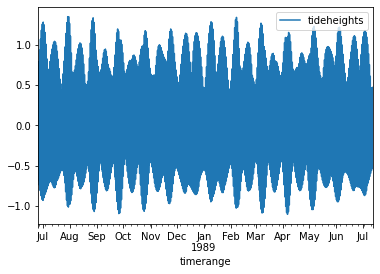

In [9]:
# ds['nidem'] = nidem
# modelledtides
modelledtides[25500:80500].plot(x='timerange', y='tideheights', kind='line') ## ~55000 values is a year in the 10 minute ds
# modelledtides.plot()

### NIDEM masking

In [10]:
## Superceeded array building cell

# ##### Build a list of DataArrays to concat

# ## Create lists to store the nidem/model masked arrays and their respective model datetimes
# da_list = []
# index_list = []

# ## Loop through the modelled data, mask nidem for tideheight at each modelled timestep/datetime
# for timestep in modelledtides[65500:69500].index:
#     exp = (ds.where(ds.nidem >= modelledtides['tideheights'][timestep])).nidem
#     da_list.append(exp)
#     index_list.append(timestep)

# ## Store modelled datetimes as a pandas index
# index = pd.Index(index_list, name='datetime')
    
# ## Concatenate the arrays on the new dimension 'datetime'
# exp_ds = xr.concat(da_list, index)

# ## View array
# # exp_ds

# %time

In [11]:
# ##### Build a list of DataArrays to concat

## Trialling some time and memory profiling to speed up the timestep loop above
## after: https://towardsdatascience.com/speed-up-jupyter-notebooks-20716cbe2025

## Identify to timeslice of interest from `modelledtides`
time_start = 25500
time_end = 80500

def exp_model(time_start, time_end):
    '''
    For each modelled timestep in modelledtides,
    mask NIDEM for the associated tideheight.
    Save the lists of timesteps and masked arrays
    and concatenate to join all arrays on the new
    dimension 'datetime'
    '''
      
    da_list = list((ds.where(ds.nidem >= modelledtides['tideheights'][timestep])).nidem 
                   for timestep in modelledtides[time_start:time_end].index) ## , drop=True signif. incr. calc. time and size of computed exp_ds
    index_list = list(timestep for timestep in modelledtides[time_start:time_end].index)
    
    ## Store modelled datetimes as a pandas index
    index = pd.Index(index_list, name='datetime')

    ## Concatenate the arrays on the new dimension 'datetime'
    exp_ds = xr.concat(da_list, index)
    
#     %reset out
    
    return exp_ds, da_list, index_list, index

exp_ds, da_list, index_list, index = exp_model(time_start, time_end)
# exp_ds = exp_ds.compute()

### Exposure map: pixel drill the binary arrays

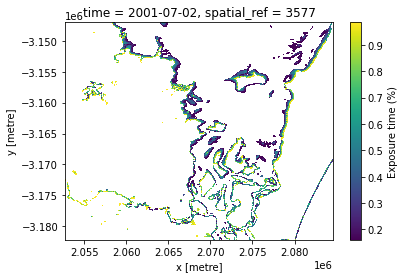

In [22]:
## Create boolean from masked arrays (exposed = true, inundated or nodata = false)
expmap = (~xr.ufuncs.isnan(exp_ds))

## Calculate the mean of the boolean across the datetime axis
pxpc = expmap.mean('datetime')

## Mask out non-intertidal areas
pxpc = pxpc.where(pxpc > 0)

## Compute the array from dask
pxpc = pxpc.compute()

## Name the exposure time array
pxpc = pxpc.rename('Exposure time (%)')

## Plot the output
pxpc.plot()

In [ ]:
# ## Stack pixels along one dimension to loop through
# expmap_stacked = expmap.stack(pixel=['y','x'])

# ## Loop through each pixel and calculate percentage of pixels that return 'True'
# ## (proxy for percentage of time that pixel is exposed)
# ## pxpc = []
# ## for x in range (0,len(expmap_stacked.pixel)):
# ##     pxpc.append(expmap_stacked.isel(pixel=x).mean().values) ##Advice from Matthew Alger: the mean of a boolean is effectively the percentage
# pxpc = list(expmap_stacked.isel(pixel=x).mean().values for x in range(0,len(expmap_stacked.pixel)))
# # pxpc = list(int(expmap_stacked.isel(pixel=x).mean().values) for x in range(0,len(expmap_stacked.pixel))) ## `int` seemed to dramatically reduce memory increase but pxpc plotted as an empty array

# ## Convert exposure results to DataArray
# pxpc = np.array(pxpc)
# pxpc = pxpc.reshape(len(expmap.y), len(expmap.x))
# pxpc = xr.DataArray(pxpc, dims=['y', 'x'])

# ## Invert y-axis
# pxpc = pxpc.reindex(y=pxpc.y[::-1])

# ## Mask out non-intertidal areas
# pxpc = pxpc.where(pxpc > 0)

# ## Assign pixel coords
# pxpc = pxpc.assign_coords({'y': expmap.coords['y'],'x':expmap.coords['x']})

# ## Name the exposure time array
# pxpc = pxpc.rename('Exposure time (%)')

# ## Plot the output
# pxpc.plot()

In [13]:
# pxpc

<xarray.DataArray 'Exposure time (%)' (time: 1, y: 1406, x: 1273)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time         (time) datetime64[ns] 2001-07-02
  * y            (y) float64 -3.147e+06 -3.147e+06 ... -3.182e+06 -3.182e+06
  * x            (x) float64 2.053e+06 2.053e+06 ... 2.085e+06 2.085e+06
    spatial_ref  int32 3577

In [14]:
# exp_ds, da_list, index_list, index = exp_model(time_start, time_end)


In [15]:
# exp_ds = exp_ds.compute()

### Code profiling

In [16]:
# %xdel da_list # Delete variable
# %xdel index_list # Delete variable
# %xdel index # Delete variable
# print(f'exp_ds is around {sys.getsizeof(exp_ds)} B')# // 1024_000 } MB')

In [17]:
# %xdel da_list # Delete variable
# import gc
# exp_ds
# print(f'index is around {sys.getsizeof(index)} B')# // 1024_000 } MB')
# %reset in # Delete automatically stored input variables
# %reset out # Delete automatically stored output variables
# gc.collect() # Force empty garbage collector

In [ ]:
## Code profiling after: https://towardsdatascience.com/speed-up-jupyter-notebooks-20716cbe2025

# %time exp_model(time_start, time_end) 
# CPU times: user 2.98 s, sys: 1.44 s, total: 4.42 s
# Wall time: 4.46 s

# %timeit -r 2 -n 5 exp_model(time_start, time_end)
# 4.31 s ± 10.3 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)

# %prun exp_model(time_start, time_end) ## two versions of this call saved below

# !pip install line_profiler
# %load_ext line_profiler
# %lprun -f exp_model exp_model(time_start, time_end)
# Timer unit: 1e-06 s

# Total time: 3.9211 s
# File: <ipython-input-18-b51d93983619>
# Function: exp_model at line 11

# Line #      Hits         Time  Per Hit   % Time  Line Contents
# ==============================================================
#     11                                           def exp_model(time_start, time_end):
#     12                                               '''
#     13                                               For each modelled timestep in modelledtides,
#     14                                               mask NIDEM for the associated tideheight.
#     15                                               Save the lists of timesteps and masked arrays
#     16                                               and concatenate to join all arrays on the new
#     17                                               dimension 'datetime'
#     18                                               '''
#     19         1          2.0      2.0      0.0      da_list = []
#     20         1          1.0      1.0      0.0      index_list = []
#     21                                               
#     22       501       4020.0      8.0      0.1      for timestep in modelledtides[time_start:time_end].index:
#     23       500    3915875.0   7831.8     99.9          exp = (ds.where(ds.nidem >= modelledtides['tideheights'][timestep])).nidem
#     24       500        857.0      1.7      0.0          da_list.append(exp)
#     25       500        346.0      0.7      0.0          index_list.append(timestep)



In [ ]:
# ## after: https://stackoverflow.com/questions/24455615/python-how-to-display-size-of-all-variables

# # import sys
# def sizeof_fmt(num, suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

# varmem = []
# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
#                          key= lambda x: -x[1])[:]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
#     varmem.append(size)
    


# # exp_ds
# sum(varmem)//1024_000

# # print(sum(varmem))
# # print(varmem)

# # %reset -f in out
# %xdel Out

# # globals().keys()
# # type(locals().items())# == globals().items()
# for name, value in locals().items():
# #     print (name if name.split('_')~==)#, value)
#     print(name)

# import gc
# gc.collect()

 Exposure map: pixel drill the binary arrays

In [ ]:
# # def exp_map(exp_ds):
# #     ## Create boolean from masked arrays (exposed = true, inundated or nodata = false)
# #     expmap = (~xr.ufuncs.isnan(exp_ds))

# #     ## Stack pixels along one dimension to loop through
# #     expmap_stacked = expmap.stack(pixel=['y','x'])

# #     ## Loop through each pixel and calculate percentage of pixels that return 'True'
# #     ## (proxy for percentage of time that pixel is exposed)
# #     pxpc = []
# #     for x in range (0,len(expmap_stacked.pixel)):
# #         pxpc.append(expmap_stacked.isel(pixel=x).mean().values) ##Advice from Matthew Alger: the mean of a boolean is effectively the percentage

# #     ## Convert exposure results to DataArray
# #     pxpc = np.array(pxpc)
# #     pxpc = pxpc.reshape(len(expmap.y), len(expmap.x))
# #     pxpc = xr.DataArray(pxpc, dims=['y', 'x'])

# #     ## Invert y-axis
# #     pxpc = pxpc.reindex(y=pxpc.y[::-1])

# #     ## Mask out non-intertidal areas
# #     pxpc = pxpc.where(pxpc > 0)

# #     ## Assign pixel coords
# #     pxpc = pxpc.assign_coords({'y': expmap.coords['y'],'x':expmap.coords['x']})

# #     ## Name the exposure time array
# #     pxpc = pxpc.rename('Exposure time (%)')

# #     ## Plot exposure map
# #     pxpc.plot(figsize=(12,8))
    
# # %lprun -f exp_map exp_map(exp_ds)

# ## Create boolean from masked arrays (exposed = true, inundated or nodata = false)
# expmap = (~xr.ufuncs.isnan(exp_ds))

# ## Stack pixels along one dimension to loop through
# expmap_stacked = expmap.stack(pixel=['y','x'])

# ## Loop through each pixel and calculate percentage of pixels that return 'True'
# ## (proxy for percentage of time that pixel is exposed)
# ## pxpc = []
# ## for x in range (0,len(expmap_stacked.pixel)):
# ##     pxpc.append(expmap_stacked.isel(pixel=x).mean().values) ##Advice from Matthew Alger: the mean of a boolean is effectively the percentage
# pxpc = list(expmap_stacked.isel(pixel=x).mean().values for x in range(0,len(expmap_stacked.pixel)))
# # pxpc = list(int(expmap_stacked.isel(pixel=x).mean().values) for x in range(0,len(expmap_stacked.pixel))) ## `int` seemed to dramatically reduce memory increase but pxpc plotted as an empty array

# ## Convert exposure results to DataArray
# pxpc = np.array(pxpc)
# pxpc = pxpc.reshape(len(expmap.y), len(expmap.x))
# pxpc = xr.DataArray(pxpc, dims=['y', 'x'])

# ## Invert y-axis
# pxpc = pxpc.reindex(y=pxpc.y[::-1])

# ## Mask out non-intertidal areas
# pxpc = pxpc.where(pxpc > 0)

# ## Assign pixel coords
# pxpc = pxpc.assign_coords({'y': expmap.coords['y'],'x':expmap.coords['x']})

# ## Name the exposure time array
# pxpc = pxpc.rename('Exposure time (%)')

### Plot: exposure and NIDEM

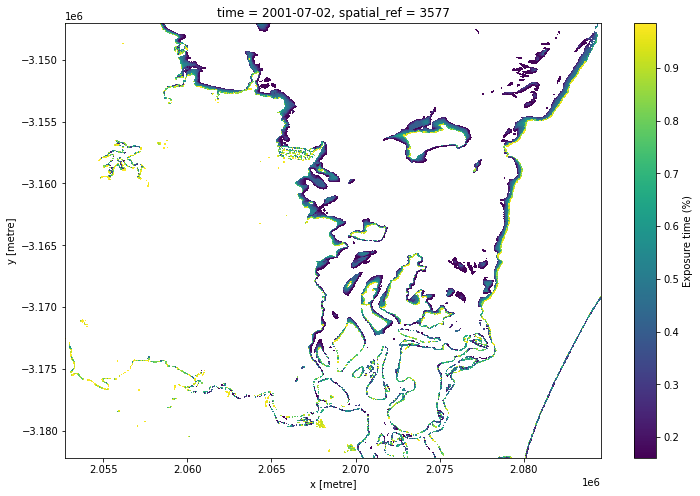

In [18]:
## Plot exposure map
pxpc.plot(figsize=(12,8))

In [ ]:
## NIDEM for comparison
ds.nidem.plot(figsize=(12,8))

### Save and export exposure map and NIDEM for aoi

In [19]:
## Save and load the 10 min modelling dataset (Note: exposure modelling performed over 14 day dataset for modelledtides[69500:71500])

## Save exposure results
pxpc.drop('time').to_netcdf("tidepost_"
               + str(tp_y) 
               + '_'
               + str(tp_x) 
               + "_pxpc_for_modelledtides10min_" 
               + str(time_start)
               + '_to_'
               + str(time_end)
               + ".nc")

# Open exposure results
# pxpc1 = xr.open_dataarray("tidepost_"+str(tp_y) + '_'+ str(tp_x) + "_pxpc_for_modelledtides10min_69500to71500.nc")
pxpc1 = xr.open_dataarray('tidepost_-27.47065_153.31303_pxpc_for_modelledtides10min_69500to71500_v3.nc')

# ## To save the NIDEM dataset to netcdf, need to remove the time dimension
# ds1 = ds.squeeze()
# ds1 = ds1.reset_coords()
# ds1.nidem.to_netcdf("tidepost_"+str(tp_y) + '_'+ str(tp_x) +'nidem.nc')

### Scatter plot: exposure vs NIDEM

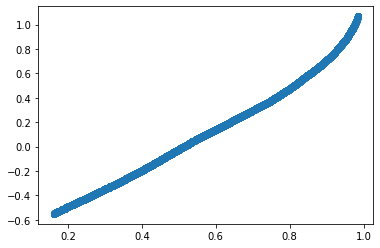

In [20]:
## Scatter plot comparing Exposure and NIDEM

# pxpc vs ds.nidem
plt.scatter(x=pxpc, y=ds.nidem)

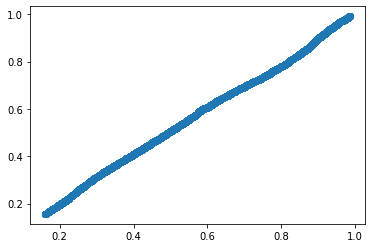

In [21]:
## Test cell

plt.scatter(x=pxpc, y=pxpc1)

# Exposure mapping approach 2

Approach 1 produces a working MVP but has significant overheads on memory usage.
Approach 2 attempts to rework the generation of the binary pixel drill to be less memory hungry (and thus enable the modelling of longer time periods as input to the exposure map - approach 1 can handle 2000 to 4000 timestamps as input to the exposure model period. This equates to 2 to 4 weeks in the 10 minute tidal model. It would be nice to extend this over a much longer period of the tidal cycle)

### Import modules

In [ ]:
import datacube
from odc.ui import with_ui_cbk
import sys

sys.path.append("../Scripts")
from dea_plotting import display_map
# from otps import TimePoint
# from otps import predict_tide
# import otps
from dea_coastaltools import tidal_tag
from dea_coastaltools import tidal_stats
from dea_dask import create_local_dask_cluster

# Import required packages
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from otps import TimePoint
from otps import predict_tide
from datacube.utils.geometry import CRS

# Fix converters for tidal plot
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
dc = datacube.Datacube(app="intertidal_exposure")
create_local_dask_cluster()

### Query and display map

In [ ]:
# Designate dask chunks
# It doesn't really matter how big the chunks we load are, as long as time ~ 1.
chunks = {"time": 1, "x": 1000, "y": 1000}

#set up our inputs to collect_training_data
products =  ['nidem']
time = ('1986', '2018')
# x = (x1, x2)
# y = (y1, y2)

## Toondah Harbour, QLD
x=(153.16984, 153.44664)
y=(-27.43959, -27.71674)
# Lat / Lon 
# 27.43959°S, 153.16984°E
# Lat / Lon 
# 27.71674°S, 153.44664°

## Southern Gladstone region, QLD
# x=(151.39537811278885, 151.96872711181226)
# y=(-23.920677965781103, -24.241642828863014)

# lon	151.39537811278885
# lat	-23.920677965781103

# lon	151.96872711181226
# lat	-24.241642828863014

# Set up the inputs for the ODC query
measurements =  ['nidem']
resolution = (-30,30)
output_crs='epsg:3577'

query = {
    'x': x,
    'y': y,
    "dask_chunks": chunks
        }

# Plot training data in an interactive map
display_map(x=x, y=y)

### Set the tidepost for tidal modelling

In [ ]:
## Toondah Harbour QLD 
tp_x = 153.31303
tp_y = -27.47065

# ## Southern Gladstone region QLD
# tp_x = 151.5934
# tp_y = -24.0299

x1=(tp_x, tp_x)
y1=(tp_y, tp_y)

display_map(x=x1, y=y1)

### Load NIDEM

In [ ]:
ds = dc.load(product='nidem',
              **query
            )
## Mask out -9999 values
ds = ds.where(ds.nidem > ds.nidem.min())

ds.nidem.plot()

### Tidal modelling
Pulling tidal modelling for a given location code out of dea_coastaltools.py script

In [ ]:
def tidal_stats(
#                 ds, 
                start='1/1/1988',
                end='1/1/2019',
                tidepost_lat=None,
                tidepost_lon=None,
                plain_english=True, 
                plot=True,
                modelled_freq='10min',
                round_stats=3): 

    # Generate range of times covering entire period of satellite record
    all_timerange = pd.date_range(start=start,
                                  end=end,
                                  freq=modelled_freq)
    all_datetimes = all_timerange.values.astype('M8[s]').astype('O').tolist()  

    # Use the tidal model to compute tide heights for each observation:  
    all_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) 
                      for dt in all_datetimes]
    all_predictedtides = predict_tide(all_timepoints)   
    all_tideheights = [predictedtide.tide_m for predictedtide 
                        in all_predictedtides]

    if plot:
        
        # Create plot and add all time and observed tide data
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(all_timerange, all_tideheights, alpha=0.4)

    return all_timerange, all_tideheights

### Load/save tidal model

In [ ]:
# all_timerange, all_tideheights = tidal_stats(tidepost_lat = tp_y,
#                                              tidepost_lon = tp_x)

# ## Save modelled tides as dataframe
#     ## Firstly convert the dates to series
# all_timerange = all_timerange.to_series()
#     ## Save dates and tideheights to pd.DataFrame
# modelledtides = pd.DataFrame(data={'timerange': all_timerange,
#                    'tideheights': all_tideheights})
#     ## Save dataframe as pickle file to avoid re-running the model
#         ## (very timely processing at 1 min intervals for 30 years!)
# modelledtides.to_pickle("tidepost_"+str(tp_y) + '_'+ str(tp_x) + "_modelledtides_10min.pkl")

'''-----------------------------------------------------------'''
# ## Load previously modelled tides for given tidepost.
modelledtides = pd.read_pickle("tidepost_"+str(tp_y) + '_'+ str(tp_x) + "_modelledtides_10min.pkl") 

### Plot a timerange for exposure modelling

In [ ]:
modelledtides[45500:89500].plot(x='timerange', y='tideheights', kind='line') ## ~55000 values is a year in the 10 minute ds
# modelledtides.plot()

### NIDEM masking

In [ ]:
# ## Approach 1

# ## Identify to timeslice of interest from `modelledtides`
# time_start = 65500
# time_end = 67500

# def exp_model(time_start, time_end):
#     '''
#     For each modelled timestep in modelledtides,
#     mask NIDEM for the associated tideheight.
#     Save the lists of timesteps and masked arrays
#     and concatenate to join all arrays on the new
#     dimension 'datetime'
#     '''
      
#     da_list = list((ds.where(ds.nidem >= modelledtides['tideheights'][timestep])).nidem 
#                    for timestep in modelledtides[time_start:time_end].index) ## , drop=True signif. incr. calc. time and size of computed exp_ds
#     index_list = list(timestep for timestep in modelledtides[time_start:time_end].index)
    
#     ## Store modelled datetimes as a pandas index
#     index = pd.Index(index_list, name='datetime')

#     ## Concatenate the arrays on the new dimension 'datetime'
#     exp_ds = xr.concat(da_list, index)
    
# #     %reset out
    
#     return exp_ds, da_list, index_list, index

# exp_ds, da_list, index_list, index = exp_model(time_start, time_end)
# %time exp_ds = exp_ds.compute()

# # CPU times: user 17.7 s, sys: 8.12 s, total: 25.8 s
# # Wall time: 30 s
# # Mem: 59.17 / 120.00 GB
  

#### Bex's suggestions
- You might be able to take the time index and directly apply it to the other array using concat
- so you should be able to add the time dimension to nidem using xarray, which will give you an xarray for each timestep.
- other suggestion is to chunk in time as well as space.
- the other option might be to start with the pixel drill, if that is all you want. essentially you may have to do this per pixel if you have too much data and do something like write the function per pixel and do ds.apply_unfunc to run it every pixel
- run pixel drill with dask and chunk in time then compute afterwards
- I would say work on reducing your data types to get the size down too - like instead of getting every elevation, get a boolean of whether or not the pixel is wet
- http://xarray.pydata.org/en/stable/generated/xarray.Dataset.expand_dims.html
- http://xarray.pydata.org/en/stable/generated/xarray.Dataset.assign_coords.html



#### Approach 2

Given nidem (as var in ds) and modelledtides, extract percentage exposure for each pixel and append to new var in ds

Plan:

- Create an empty var in ds to store % values as they're generated
- for pixel in ds.nidem:
    - create empty list of len(modelledtides[a:b])
    - for datetime in modelledtides[a:b]:
        - if modelledtideheight <= nidem:
            - list.append("True")
        - else:
            - list.append("False")
    - calculate percentage of "True" observations in list
    - for `pixel` coords, add `percentage` value to corresponding position in new `empty` var of ds

In [ ]:
exp = ds.nidem
ds['exposure'] = exp

ds = ds.compute()

In [ ]:
## Test cell

test = xr.DataArray

In [ ]:
def exp_map(group, modelledtides, time_start, time_end):    
   
    # Run the pixel drill for exposure
    px_exp = []
    for timestep in modelledtides[time_start:time_end].index:
        if modelledtides['tideheights'][timestep] <= group.nidem.values[0][0]:
            px_exp.append("True")
        else:
            px_exp.append("False")
                
    # Calculate the percentage of "True" observations for the pixel
    px_true = px_exp.count('True')
    px_obs = len(px_exp)
    px_pc= px_true//px_obs
    
    # Update the value in the `exposure` array
    ds.exposure.loc[dict(x=group.x.values, y=group.y.values)] = px_pc

time_start = 65500
time_end = 66000

## Set exposure variable to nan to be later overwritten by exp values - FIND OUT HOW TO INITIATE AN EMPTY VAR WITH IDENTICAL DIMS TO DS. THIS IS WORKFLOW LOOP IS SO SLOW AS TO BE UNUSEFUL
for label1, group1 in ds.groupby('x'):
    for label, group in group1.groupby('y'):
        ds.exposure.loc[dict(x=group.x, y=group.y)] = -9998

# for label1, group1 in ds.groupby('x'):
#     for label, group in group1.groupby('y'):
# #         print(group.nidem.values)
#         exp_map(group, modelledtides, time_start, time_end)
        
# %time

In [ ]:
# ds#.nidem.plot()# == ds.nidem

# group.nidem.values[0][0]
# group.x.values
# exp_map(group, modelledtides, time_start, time_end)

ds.exposure.plot()

In [ ]:
# ds.exposure.iloc[str(group.x.values)]
# print(str(group.x.values), str(group.y.values))

In [ ]:
ds

In [ ]:
# #### - Create an empty var in ds to store % values as they're generated(maybe not)

# time_start = 65500
# time_end = 66000


# px_pc_1D = []
# for x in range(0, len(ds.nidem.x)):
#     for y in range(0, len(ds.nidem.y)):      
#         px_exp = []
#         for timestep in modelledtides[time_start:time_end].index:
#             if modelledtides['tideheights'][timestep] <= ds.nidem[0][x][y]:
#                 px_exp.append("True")
#             else:
#                 px_exp.append("False")
                
#         # Calculate the percentage of "True" observations for the pixel
#         px_true = px_exp.count('True')
#         px_obs = len(px_exp)
#         px_pc= px_true//px_obs
        
#         px_pc_1D.append(px_pc)
# #     - calculate percentage of "True" observations in list
# #     - append `percentage` to new list
    
# # - reshape `percentage` list and append as new variable to ds


# #Accessing individual pixels using groupby

# test=list(ds.groupby('x'))

# for x in test:
#     xy = test[x][1].groupby('y')

In [ ]:
# test=[]
# test.append(px_exp[x] == "True" for x in px_exp)
# len(test)
# px_exp.count("False")
# modelledtides['tideheights'][60000]
# ds.nidem[0][0][0]

# for group in list(ds.groupby('x')):
#     print(group[0].groupby('y'))
# #     print(group)

# test=list(ds.groupby('x'))

In [ ]:
# test[0][1].groupby('y').groups
# ds.apply

In [ ]:
# #### - Create an empty var in ds to store % values as they're generated(maybe not)
# time_start = 65500
# time_end = 66000

# px_pc_1D = []
# for x in range(0, len(ds.nidem.x)):
#     for y in range(0, len(ds.nidem.y)):      
#         px_exp = []
#         for timestep in modelledtides[time_start:time_end].index:
#             if modelledtides['tideheights'][timestep] <= ds.nidem[0][x][y]:
#                 px_exp.append("True")
#             else:
#                 px_exp.append("False")
                
#         # Calculate the percentage of "True" observations for the pixel
#         px_true = px_exp.count('True')
#         px_obs = len(px_exp)
#         px_pc= px_true//px_obs
        
#         px_pc_1D.append(px_pc)
# #     - calculate percentage of "True" observations in list
# #     - append `percentage` to new list
    
# # - reshape `percentage` list and append as new variable to ds

In [ ]:
# #Accessing individual pixels using groupby

# test=list(ds.groupby('x'))
# test1 = list(test[0][1].groupby('y'))


# ds.exposure.loc[dict(x=2052762.5, y=-3147037.5)] = 1

In [ ]:
# test1[0][1].exposure.values = [[0]]
# test1[0][1].exposure.values
# # for x in test:
# #     test1 = list(test[x][1].groupby('y'))
# #         for y in test1:
# #             test1[y][1].map(func)

# for x in ds.groupby('x'):
#     print(x)

# for label, group in ds.groupby('x'):
#     for label2, group2 in group.groupby('y'):
#         print(group2)

In [ ]:
# def test(x):
#     return x=0

# ds.exposure.groupby('x').map(test)

In [ ]:
# ## Testing cell

# print(ds)
exp = ds.nidem
ds['exposure'] = exp
ds

## Trying to create an empty array that can be added to ds
# locs = ["IA", "IL", "IN"]

# times = pd.date_range("2000-01-01", periods=4)

# data = np.random.rand(4, 3)

# foo = xr.DataArray(data, coords=[times, locs], dims=["time", "space"])

In [ ]:
ds=ds.compute()

In [ ]:
# len(ds.nidem.x)

# DA.loc[dict(axis_A="A_1", axis_B="B_1", axis_C="C_1")] = 1

ds.exposure.loc[dict(x=2052762.5, y=-3147037.5)] = 1
ds.exposure

In [ ]:
# ds.exposure[0][0][0].load()#update()
ds.exposure[0][0][0].values

In [ ]:
ds.exposure[0][0][0].values = 'True'

In [ ]:
ds.exposure[0][0][0].values

# Other

# ## %prun incl. concatenate in function call
# %prun exp_model(time_start, time_end)

# 3208896 function calls (3146768 primitive calls) in 5.302 seconds

#    Ordered by: internal time

#    ncalls  tottime  percall  cumtime  percall filename:lineno(function)
#      9993    3.018    0.000    3.088    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
#  1000/500    0.213    0.000    0.244    0.000 {built-in method _operator.ge}
# 277368/274320    0.064    0.000    0.130    0.000 {built-in method builtins.isinstance}
#      4504    0.059    0.000    0.248    0.000 dataset.py:1167(_construct_dataarray)
# 137027/134527    0.051    0.000    0.204    0.000 {built-in method builtins.getattr}
#     85063    0.050    0.000    0.104    0.000 typing.py:1227(__new__)
#         1    0.044    0.044    5.303    5.303 <string>:1(<module>)
# 171743/126174    0.040    0.000    0.098    0.000 {built-in method builtins.len}
#      9987    0.040    0.000    0.040    0.000 {method 'reduce' of 'numpy.ufunc' objects}
#     85063    0.040    0.000    0.054    0.000 typing.py:1180(_generic_new)
#     50535    0.039    0.000    0.102    0.000 dataset.py:567(variables)
#      2996    0.034    0.000    0.300    0.000 missing.py:358(array_equivalent)
# 49109/45609    0.030    0.000    0.160    0.000 {built-in method builtins.hasattr}
#     43051    0.028    0.000    0.121    0.000 utils.py:531(ndim)
#     14517    0.025    0.000    0.070    0.000 variable.py:185(as_compatible_data)
# 72563/71061    0.025    0.000    0.027    0.000 common.py:251(__setattr__)
#      2500    0.023    0.000    0.625    0.000 common.py:221(__getattr__)
#      4500    0.023    0.000    0.122    0.000 dataarray.py:377(_replace_maybe_drop_dims)
#      5992    0.023    0.000    0.139    0.000 missing.py:193(_isna_ndarraylike)
#     10005    0.022    0.000    0.039    0.000 dataarray.py:266(__init__)
#      6000    0.021    0.000    0.305    0.000 dataarray.py:624(_getitem_coord)
#      9508    0.021    0.000    0.149    0.000 base.py:1242(set_names)
#     14017    0.021    0.000    0.141    0.000 variable.py:306(__init__)
#     43046    0.020    0.000    0.031    0.000 _collections_abc.py:742(__iter__)
#     28528    0.020    0.000    0.042    0.000 {pandas._libs.lib.is_list_like}
#     45056    0.019    0.000    0.085    0.000 variable.py:339(shape)
#    122594    0.018    0.000    0.018    0.000 variable.py:545(dims)
#     98584    0.017    0.000    0.017    0.000 {built-in method __new__ of type object at 0x9d12c0}
#      7013    0.017    0.000    0.049    0.000 utils.py:69(_maybe_cast_to_cftimeindex)
#     60005    0.017    0.000    0.036    0.000 generic.py:10(_check)
#       503    0.017    0.000    0.428    0.001 alignment.py:61(align)
#     28053    0.016    0.000    0.023    0.000 <frozen importlib._bootstrap>:416(parent)
#      5506    0.016    0.000    0.044    0.000 coordinates.py:208(<dictcomp>)
#     14017    0.016    0.000    0.049    0.000 variable.py:554(_parse_dimensions)
#     16538    0.015    0.000    0.015    0.000 {method 'view' of 'numpy.ndarray' objects}
#      8008    0.015    0.000    0.170    0.000 variable.py:2492(to_index)
#     45569    0.015    0.000    0.070    0.000 base.py:563(__len__)
#      7009    0.015    0.000    0.193    0.000 variable.py:2435(copy)
#     37082    0.014    0.000    0.014    0.000 _weakrefset.py:70(__contains__)
#     79562    0.014    0.000    0.015    0.000 utils.py:425(__getitem__)
#     38556    0.014    0.000    0.087    0.000 indexing.py:1418(shape)
#      5506    0.014    0.000    0.081    0.000 coordinates.py:205(variables)
#     25030    0.014    0.000    0.092    0.000 coordinates.py:61(__iter__)
#      8002    0.013    0.000    0.037    0.000 base.py:494(_shallow_copy)
#      5992    0.013    0.000    0.047    0.000 fromnumeric.py:73(_wrapreduction)
#      9508    0.013    0.000    0.035    0.000 base.py:1212(_set_names)
#     28528    0.013    0.000    0.022    0.000 abc.py:180(__instancecheck__)
#     19526    0.013    0.000    0.017    0.000 copy.py:66(copy)
#      8002    0.013    0.000    0.018    0.000 base.py:459(_simple_new)
#       500    0.013    0.000    2.033    0.004 computation.py:584(apply_variable_ufunc)
#      5006    0.012    0.000    0.067    0.000 variable.py:953(_replace)
#      4501    0.012    0.000    0.040    0.000 utils.py:284(is_scalar)
#      7010    0.011    0.000    0.109    0.000 variable.py:2340(__init__)
#     29561    0.011    0.000    0.032    0.000 <frozen importlib._bootstrap>:997(_handle_fromlist)
#     14535    0.010    0.000    0.036    0.000 _mixins.py:70(shape)
#      6492    0.010    0.000    0.166    0.000 missing.py:130(_isna)
#      3998    0.010    0.000    0.335    0.000 base.py:4192(equals)
#     17000    0.010    0.000    0.015    0.000 dataarray.py:585(dims)
#     39045    0.010    0.000    0.033    0.000 {built-in method builtins.issubclass}
#      4500    0.010    0.000    0.012    0.000 dataarray.py:397(<dictcomp>)
#      1500    0.010    0.000    0.142    0.000 dataarray.py:609(_level_coords)
#     62044    0.009    0.000    0.009    0.000 utils.py:422(__init__)
#       500    0.009    0.000    3.029    0.006 computation.py:770(apply_ufunc)
# 16000/14998    0.009    0.000    0.011    0.000 {built-in method numpy.array}
#     15015    0.009    0.000    0.009    0.000 variable.py:854(attrs)
#       500    0.009    0.000    0.032    0.000 dataset.py:5035(_copy_attrs_from)
#      7028    0.009    0.000    0.023    0.000 typing.py:1145(__subclasscheck__)
#     47554    0.009    0.000    0.009    0.000 coordinates.py:197(_names)
#      9002    0.009    0.000    0.025    0.000 common.py:1460(is_extension_array_dtype)
#      1000    0.009    0.000    0.059    0.000 variable.py:1404(set_dims)
#     11986    0.009    0.000    0.025    0.000 common.py:566(is_string_dtype)
#       500    0.009    0.000    0.010    0.000 datetimes.py:629(_maybe_cast_for_get_loc)
#      5501    0.008    0.000    0.030    0.000 dataarray.py:362(_replace)
#      9002    0.008    0.000    0.011    0.000 base.py:413(find)
#       502    0.008    0.000    0.410    0.001 alignment.py:347(deep_align)
#       500    0.008    0.000    0.008    0.000 {method 'get_loc' of 'pandas._libs.index.DatetimeEngine' objects}
#      2503    0.008    0.000    0.037    0.000 dataset.py:859(_construct_direct)
#     12001    0.008    0.000    0.043    0.000 base.py:256(is_dtype)
#      7500    0.008    0.000    0.021    0.000 dataarray.py:713(coords)
#     11999    0.008    0.000    0.015    0.000 common.py:1600(_is_dtype_type)
#      3006    0.008    0.000    0.031    0.000 datetimelike.py:640(_shallow_copy)
#      4504    0.007    0.000    0.263    0.000 dataset.py:1262(__getitem__)
#      7010    0.007    0.000    0.063    0.000 indexing.py:1388(__init__)
#     14534    0.007    0.000    0.043    0.000 _mixins.py:74(__len__)
#      4500    0.007    0.000    0.050    0.000 indexes.py:130(propagate_indexes)
#      1003    0.007    0.000    0.022    0.000 dataset.py:187(calculate_dimensions)
#      3008    0.007    0.000    0.021    0.000 datetimes.py:285(_simple_new)
#     16534    0.007    0.000    0.022    0.000 datetimelike.py:491(asi8)
#     11986    0.007    0.000    0.016    0.000 common.py:1541(_is_dtype)
#      5992    0.007    0.000    0.054    0.000 fromnumeric.py:2843(prod)
#       500    0.007    0.000    0.027    0.000 merge.py:289(collect_from_coordinates)
#      8002    0.007    0.000    0.044    0.000 numeric.py:105(_shallow_copy)
#     28053    0.007    0.000    0.007    0.000 {method 'rpartition' of 'str' objects}
#      4003    0.007    0.000    0.018    0.000 dataset.py:600(dims)
#         2    0.007    0.003    0.217    0.109 concat.py:243(process_subset_opt)
#     18017    0.006    0.000    0.016    0.000 utils.py:428(__iter__)
#       500    0.006    0.000    3.012    0.006 computation.py:378(apply_dataset_vfunc)
#      7028    0.006    0.000    0.014    0.000 abc.py:196(__subclasscheck__)
#         1    0.006    0.006    5.258    5.258 <ipython-input-14-92da67a113d7>:11(exp_model)
#      5997    0.006    0.000    0.027    0.000 dtypes.py:903(is_dtype)
#      5992    0.006    0.000    0.080    0.000 common.py:1180(needs_i8_conversion)
#      6509    0.006    0.000    0.016    0.000 dataset.py:1380(coords)
#      7009    0.006    0.000    0.069    0.000 indexing.py:1469(copy)
#       503    0.006    0.000    0.195    0.000 merge.py:163(merge_collected)
#     14517    0.006    0.000    0.008    0.000 variable.py:165(_maybe_wrap_data)
#       500    0.006    0.000    0.012    0.000 coordinates.py:120(_merge_raw)
#       500    0.006    0.000    0.244    0.000 variable.py:2121(func)
#      5992    0.006    0.000    0.014    0.000 common.py:1025(is_datetime_or_timedelta_dtype)
#      1500    0.005    0.000    0.163    0.000 dataarray.py:674(<dictcomp>)
# 23023/19521    0.005    0.000    0.011    0.000 {built-in method builtins.iter}
#      7013    0.005    0.000    0.056    0.000 utils.py:87(safe_cast_to_index)
# 15499/14497    0.005    0.000    0.016    0.000 _asarray.py:16(asarray)
#     14535    0.005    0.000    0.025    0.000 datetimelike.py:464(_ndarray)
#      5006    0.005    0.000    0.073    0.000 variable.py:872(copy)
#     13993    0.005    0.000    0.007    0.000 common.py:1565(_get_dtype)
#     13022    0.005    0.000    0.007    0.000 inference.py:322(is_hashable)
#      7012    0.005    0.000    0.130    0.000 {built-in method builtins.any}
#      1502    0.005    0.000    0.175    0.000 dataset.py:1087(<dictcomp>)
#      5992    0.005    0.000    0.064    0.000 <__array_function__ internals>:2(prod)
#      6000    0.005    0.000    0.033    0.000 common.py:456(is_period_dtype)
#       501    0.005    0.000    0.008    0.000 frame.py:2869(__getitem__)
#      1500    0.005    0.000    0.029    0.000 datetimelike.py:129(equals)
#      5995    0.005    0.000    0.028    0.000 common.py:381(is_datetime64tz_dtype)
#       999    0.004    0.000    0.012    0.000 numeric.py:2287(array_equal)
#      1500    0.004    0.000    0.176    0.000 dataarray.py:669(_item_sources)
#      4507    0.004    0.000    0.109    0.000 variable.py:2510(level_names)
#     26036    0.004    0.000    0.004    0.000 {method 'items' of 'dict' objects}
#     23504    0.004    0.000    0.004    0.000 dataarray.py:529(variable)
#      9508    0.004    0.000    0.015    0.000 utils.py:250(is_duck_array)
#       500    0.004    0.000    2.174    0.004 computation.py:344(apply_dict_of_variables_vfunc)
#      1000    0.004    0.000    0.030    0.000 variable.py:1364(transpose)
#      1000    0.004    0.000    0.187    0.000 dataset.py:1205(_item_sources)
#       500    0.004    0.000    3.041    0.006 common.py:1159(where)
# 23063/23062    0.004    0.000    0.004    0.000 {built-in method builtins.hash}
#     11010    0.004    0.000    0.004    0.000 base.py:540(_reset_identity)
#      6000    0.004    0.000    0.309    0.000 coordinates.py:282(__getitem__)
#      9012    0.004    0.000    0.134    0.000 utils.py:238(is_dict_like)
#      7508    0.004    0.000    0.005    0.000 _collections_abc.py:676(items)
#      1502    0.004    0.000    0.196    0.000 dataset.py:988(copy)
#     11997    0.004    0.000    0.006    0.000 common.py:180(<lambda>)
#       500    0.004    0.000    0.275    0.001 dataarray.py:2754(func)
#      7028    0.004    0.000    0.031    0.000 typing.py:1156(__instancecheck__)
#      5498    0.004    0.000    0.005    0.000 base.py:516(is_)
#     11986    0.003    0.000    0.003    0.000 common.py:595(condition)
#      1504    0.003    0.000    0.014    0.000 dataset.py:885(_replace)
#      1500    0.003    0.000    0.047    0.000 base.py:789(copy)
#       500    0.003    0.000    0.006    0.000 computation.py:489(unified_dim_sizes)
#      8009    0.003    0.000    0.005    0.000 variable.py:2528(name)
#      1500    0.003    0.000    0.005    0.000 dataset.py:139(_get_virtual_variable)
#     13010    0.003    0.000    0.003    0.000 {method 'copy' of 'dict' objects}
#      3502    0.003    0.000    0.003    0.000 {built-in method builtins.sorted}
#     22028    0.003    0.000    0.003    0.000 {method 'get' of 'dict' objects}
#      5992    0.003    0.000    0.003    0.000 fromnumeric.py:74(<dictcomp>)
#       500    0.003    0.000    3.033    0.006 ops.py:174(where_method)
#      1500    0.003    0.000    0.126    0.000 computation.py:324(_as_variables_or_variable)
#      3001    0.003    0.000    0.008    0.000 common.py:194(is_object_dtype)
#       500    0.003    0.000    0.024    0.000 computation.py:364(_fast_dataset)
#      1000    0.003    0.000    0.007    0.000 _ufunc_config.py:39(seterr)
#      7005    0.003    0.000    0.011    0.000 extension.py:53(fget)
#      2506    0.003    0.000    0.008    0.000 dataset.py:1387(data_vars)
#      6492    0.003    0.000    0.169    0.000 missing.py:47(isna)
#      5005    0.003    0.000    0.004    0.000 _collections_abc.py:657(get)
#      3008    0.003    0.000    0.012    0.000 base.py:1178(name)
#     22025    0.003    0.000    0.003    0.000 {method 'append' of 'list' objects}
#     12510    0.003    0.000    0.003    0.000 base.py:1171(name)
#      3502    0.003    0.000    0.003    0.000 base.py:36(is_dask_collection)
#       501    0.003    0.000    0.010    0.000 dtypes.py:144(result_type)
#       500    0.003    0.000    0.004    0.000 stride_tricks.py:116(_broadcast_to)
#      3013    0.003    0.000    0.009    0.000 base.py:5650(maybe_extract_name)
#      4002    0.003    0.000    0.021    0.000 variable.py:354(data)
#      3507    0.003    0.000    0.033    0.000 dataset.py:1373(indexes)
#      8500    0.003    0.000    0.005    0.000 _collections_abc.py:719(__iter__)
#      4500    0.003    0.000    0.111    0.000 alignment.py:300(<genexpr>)
#      4002    0.003    0.000    0.008    0.000 pycompat.py:14(is_duck_dask_array)
#       505    0.003    0.000    0.042    0.000 merge.py:80(unique_variable)
#      4500    0.003    0.000    0.003    0.000 indexes.py:141(<dictcomp>)
#      7000    0.003    0.000    0.003    0.000 contextlib.py:245(__exit__)
#     13996    0.003    0.000    0.003    0.000 base.py:3866(_values)
#     11997    0.003    0.000    0.003    0.000 common.py:178(classes)
#      3000    0.003    0.000    0.007    0.000 common.py:1296(is_float_dtype)
#       500    0.003    0.000    0.005    0.000 common.py:176(sizes)
#      3995    0.002    0.000    0.017    0.000 {method 'all' of 'numpy.ndarray' objects}
#       500    0.002    0.000    0.112    0.000 dataarray.py:855(copy)
#      1000    0.002    0.000    0.003    0.000 _ufunc_config.py:139(geterr)
#       500    0.002    0.000    0.028    0.000 datetimes.py:577(get_loc)
#      1001    0.002    0.000    3.027    0.003 duck_array_ops.py:44(f)
#       500    0.002    0.000    0.232    0.000 computation.py:196(build_output_coords)
#      1500    0.002    0.000    0.180    0.000 dataarray.py:664(_attr_sources)
#      7000    0.002    0.000    0.002    0.000 contextlib.py:239(__init__)
#         1    0.002    0.002    0.026    0.026 concat.py:337(_parse_datasets)
#     10009    0.002    0.000    0.002    0.000 _collections_abc.py:698(__init__)
#      1500    0.002    0.000    0.005    0.000 base.py:1189(_validate_names)
#       500    0.002    0.000    0.033    0.000 series.py:974(_get_value)
#      7996    0.002    0.000    0.002    0.000 {pandas._libs.lib.is_scalar}
#      5037    0.002    0.000    0.003    0.000 utils.py:588(__hash__)
#       500    0.002    0.000    1.977    0.004 duck_array_ops.py:273(where)
#      1501    0.002    0.000    0.002    0.000 {method 'astype' of 'numpy.ndarray' objects}
#      1000    0.002    0.000    0.169    0.000 dataset.py:1211(<dictcomp>)
#      4504    0.002    0.000    0.003    0.000 utils.py:633(hashable)
#       501    0.002    0.000    0.020    0.000 duck_array_ops.py:187(as_shared_dtype)
#      1001    0.002    0.000    0.009    0.000 common.py:150(get_axis_num)
#       500    0.002    0.000    0.003    0.000 computation.py:66(__init__)
#       998    0.002    0.000    0.149    0.000 variable.py:2483(_data_equals)
#      3502    0.002    0.000    0.006    0.000 utils.py:465(__iter__)
#     10015    0.002    0.000    0.002    0.000 indexes.py:63(__getitem__)
#       500    0.002    0.000    0.036    0.000 series.py:868(__getitem__)
#      3006    0.002    0.000    0.002    0.000 dataset.py:383(<genexpr>)
#      2500    0.002    0.000    0.002    0.000 dataarray.py:706(indexes)
#      1501    0.002    0.000    0.004    0.000 {method 'update' of 'dict' objects}
#      1500    0.002    0.000    0.020    0.000 variable.py:1739(equals)
#       500    0.002    0.000    0.002    0.000 variable.py:2541(_unified_dims)
#      1500    0.002    0.000    0.002    0.000 {method 'format' of 'str' objects}
#      1003    0.002    0.000    0.003    0.000 dataset.py:195(<setcomp>)
#      2504    0.002    0.000    0.002    0.000 dataset.py:1188(<dictcomp>)
#      1500    0.002    0.000    0.002    0.000 frozen.py:66(__getitem__)
#     13010    0.002    0.000    0.002    0.000 copy.py:111(_copy_immutable)
#       500    0.002    0.000    0.049    0.000 dataarray.py:929(<dictcomp>)
#      1499    0.002    0.000    0.170    0.000 variable.py:2471(equals)
#      3000    0.002    0.000    0.002    0.000 utils.py:707(infix_dims)
#       500    0.002    0.000    0.005    0.000 computation.py:184(_get_coords_list)
#      5501    0.002    0.000    0.002    0.000 variable.py:847(attrs)
#       500    0.002    0.000    0.006    0.000 dataset.py:402(variables)
#      1000    0.002    0.000    0.189    0.000 dataset.py:1200(_attr_sources)
#         1    0.002    0.002    1.635    1.635 concat.py:489(_dataarray_concat)
#       500    0.002    0.000    0.003    0.000 computation.py:280(ordered_set_intersection)
#      7500    0.002    0.000    0.002    0.000 coordinates.py:271(__init__)
#      3995    0.002    0.000    0.015    0.000 _methods.py:47(_all)
#      2001    0.001    0.000    0.003    0.000 <__array_function__ internals>:2(result_type)
#       500    0.001    0.000    0.004    0.000 variable.py:2590(_broadcast_compat_data)
#       500    0.001    0.000    0.002    0.000 merge.py:59(broadcast_dimension_size)
#       500    0.001    0.000    0.012    0.000 base.py:2847(get_loc)
#      2000    0.001    0.000    0.002    0.000 dataarray.py:686(attrs)
#      1000    0.001    0.000    0.061    0.000 dataset.py:394(__getitem__)
#       501    0.001    0.000    0.031    0.000 concat.py:442(ensure_common_dims)
#       500    0.001    0.000    0.014    0.000 dataarray.py:450(_to_dataset_whole)
#      1002    0.001    0.000    0.042    0.000 _collections_abc.py:760(__iter__)
#      1505    0.001    0.000    0.015    0.000 {method 'update' of 'set' objects}
#      8508    0.001    0.000    0.001    0.000 base.py:1374(nlevels)
#      6509    0.001    0.000    0.001    0.000 coordinates.py:194(__init__)
#       500    0.001    0.000    0.051    0.000 dataarray.py:925(<dictcomp>)
#         1    0.001    0.001    1.619    1.619 concat.py:364(_dataset_concat)
#       500    0.001    0.000    0.004    0.000 computation.py:607(<listcomp>)
#      2000    0.001    0.000    0.002    0.000 _collections_abc.py:672(keys)
#      1000    0.001    0.000    0.003    0.000 coordinates.py:305(variables)
#      1002    0.001    0.000    0.003    0.000 indexing.py:1408(__array__)
#         1    0.001    0.001    0.226    0.226 concat.py:220(_calc_concat_over)
#       500    0.001    0.000    0.001    0.000 base.py:4032(__contains__)
#      2011    0.001    0.000    0.001    0.000 merge.py:199(<listcomp>)
#      1524    0.001    0.000    0.002    0.000 typing.py:1033(_abc_negative_cache_version)
#       500    0.001    0.000    0.004    0.000 variable.py:2573(broadcast_variables)
#      4006    0.001    0.000    0.002    0.000 dtypes.py:163(<genexpr>)
#      3501    0.001    0.000    0.005    0.000 duck_array_ops.py:49(<genexpr>)
#      5006    0.001    0.000    0.001    0.000 utils.py:434(__contains__)
#      1500    0.001    0.000    0.001    0.000 base.py:1209(_get_names)
#      1000    0.001    0.000    0.001    0.000 {built-in method numpy.seterrobj}
#      2000    0.001    0.000    0.002    0.000 computation.py:105(num_outputs)
#       501    0.001    0.000    0.003    0.000 dtypes.py:160(<setcomp>)
#       500    0.001    0.000    1.982    0.004 duck_array_ops.py:278(where_method)
#      6007    0.001    0.000    0.001    0.000 indexes.py:44(__init__)
#      1000    0.001    0.000    0.001    0.000 computation.py:73(all_input_core_dims)
#      5030    0.001    0.000    0.001    0.000 datetimes.py:478(dtype)
#       998    0.001    0.000    0.028    0.000 variable.py:440(compute)
#       500    0.001    0.000    0.223    0.000 merge.py:304(merge_coordinates_without_align)
#      1500    0.001    0.000    0.003    0.000 coordinates.py:50(indexes)
#      1500    0.001    0.000    0.001    0.000 {method 'split' of 'str' objects}
#       500    0.001    0.000    0.003    0.000 concat.py:240(<genexpr>)
#       500    0.001    0.000    0.003    0.000 base.py:4619(_get_values_for_loc)
#       999    0.001    0.000    0.014    0.000 <__array_function__ internals>:2(array_equal)
#       500    0.001    0.000    0.003    0.000 numerictypes.py:365(issubdtype)
#      5992    0.001    0.000    0.001    0.000 fromnumeric.py:2838(_prod_dispatcher)
#      1503    0.001    0.000    0.001    0.000 dataset.py:381(__iter__)
#      1006    0.001    0.000    0.044    0.000 {built-in method builtins.all}
#      7000    0.001    0.000    0.001    0.000 contextlib.py:242(__enter__)
#      1000    0.001    0.000    0.002    0.000 computation.py:517(broadcast_compat_data)
#      1500    0.001    0.000    0.002    0.000 dataarray.py:538(shape)
#      2000    0.001    0.000    0.003    0.000 computation.py:602(<genexpr>)
#       500    0.001    0.000    0.006    0.000 variable.py:1757(broadcast_equals)
#      2000    0.001    0.000    0.004    0.000 computation.py:613(<genexpr>)
#       500    0.001    0.000    0.002    0.000 base.py:4972(_maybe_cast_indexer)
#       500    0.001    0.000    0.004    0.000 dtypes.py:45(maybe_promote)
#      1504    0.001    0.000    0.004    0.000 duck_array_ops.py:183(asarray)
#       500    0.001    0.000    0.127    0.000 computation.py:350(<listcomp>)
#      1001    0.001    0.000    0.002    0.000 common.py:608(is_dtype_equal)
#      2001    0.001    0.000    0.002    0.000 common.py:170(_get_axis_num)
#      1500    0.001    0.000    0.002    0.000 computation.py:89(all_core_dims)
#       500    0.001    0.000    0.004    0.000 _ufunc_config.py:446(__exit__)
#      4003    0.001    0.000    0.001    0.000 utils.py:453(__init__)
#      1002    0.001    0.000    0.001    0.000 dataset.py:596(encoding)
#       500    0.001    0.000    0.029    0.000 indexes.py:87(<dictcomp>)
#       500    0.001    0.000    0.006    0.000 computation.py:307(join_dict_keys)
#      1524    0.001    0.000    0.001    0.000 typing.py:1019(_abc_negative_cache)
#      3000    0.001    0.000    0.002    0.000 common.py:166(<genexpr>)
#       500    0.001    0.000    0.001    0.000 managers.py:1613(internal_values)
#      1000    0.001    0.000    0.001    0.000 numerictypes.py:293(issubclass_)
#       500    0.001    0.000    1.950    0.004 <__array_function__ internals>:2(where)
#       500    0.001    0.000    0.001    0.000 computation.py:81(all_output_core_dims)
#       503    0.001    0.000    0.001    0.000 alignment.py:20(_get_joiner)
#       500    0.001    0.000    0.005    0.000 _ufunc_config.py:441(__enter__)
#       500    0.001    0.000    0.002    0.000 computation.py:311(<listcomp>)
#       500    0.001    0.000    0.002    0.000 dataset.py:405(<dictcomp>)
#      1500    0.001    0.000    0.001    0.000 coordinates.py:340(__getitem__)
#       500    0.001    0.000    0.001    0.000 dataarray.py:2712(_result_name)
#      4012    0.001    0.000    0.001    0.000 {method 'setdefault' of 'dict' objects}
#      2001    0.001    0.000    0.001    0.000 dataset.py:578(attrs)
#      1002    0.001    0.000    0.006    0.000 variable.py:255(_as_array_or_item)
#       500    0.001    0.000    0.133    0.000 computation.py:408(<listcomp>)
#      2000    0.001    0.000    0.001    0.000 {built-in method numpy.geterrobj}
#      1500    0.001    0.000    0.001    0.000 computation.py:599(<genexpr>)
#      1510    0.001    0.000    0.006    0.000 alignment.py:366(is_alignable)
#      2000    0.001    0.000    0.001    0.000 computation.py:67(<genexpr>)
#       500    0.001    0.000    0.002    0.000 missing.py:571(is_valid_nat_for_dtype)
#       500    0.001    0.000    0.001    0.000 _ufunc_config.py:437(__init__)
#      2506    0.001    0.000    0.001    0.000 dataset.py:378(__init__)
#      1500    0.001    0.000    0.001    0.000 variable.py:2586(<genexpr>)
#      2000    0.001    0.000    0.001    0.000 computation.py:1073(<genexpr>)
#      1502    0.001    0.000    0.001    0.000 {method 'copy' of 'set' objects}
#       501    0.001    0.000    0.003    0.000 duck_array_ops.py:201(<listcomp>)
#      2500    0.001    0.000    0.001    0.000 concat.py:451(<genexpr>)
#       501    0.001    0.000    0.004    0.000 duck_array_ops.py:195(<listcomp>)
#       500    0.001    0.000    0.001    0.000 base.py:1751(is_floating)
#       500    0.001    0.000    0.001    0.000 dataarray.py:696(encoding)
#       500    0.001    0.000    0.001    0.000 dataset.py:585(attrs)
#      2500    0.001    0.000    0.001    0.000 coordinates.py:337(__init__)
#      1002    0.001    0.000    0.001    0.000 dataset.py:589(encoding)
#      1000    0.001    0.000    0.001    0.000 computation.py:1091(<genexpr>)
#         1    0.001    0.001    0.001    0.001 {pandas._libs.tslibs.vectorized.ints_to_pydatetime}
#      1011    0.001    0.000    0.042    0.000 alignment.py:425(<genexpr>)
#      1001    0.001    0.000    0.001    0.000 common.py:329(apply_if_callable)
#       501    0.001    0.000    0.004    0.000 dataset.py:1227(__iter__)
#       500    0.001    0.000    0.001    0.000 generic.py:3529(_get_item_cache)
#       500    0.001    0.000    0.002    0.000 series.py:540(_values)
#      1000    0.000    0.000    0.001    0.000 variable.py:2591(<genexpr>)
#       501    0.000    0.000    0.001    0.000 datetimes.py:500(tz)
#       500    0.000    0.000    0.004    0.000 computation.py:315(collect_dict_values)
#       500    0.000    0.000    0.001    0.000 dataarray.py:702(encoding)
#       501    0.000    0.000    0.001    0.000 datetimes.py:549(__iter__)
#       501    0.000    0.000    0.001    0.000 duck_array_ops.py:190(<listcomp>)
#       500    0.000    0.000    0.003    0.000 computation.py:319(<listcomp>)
#      1501    0.000    0.000    0.000    0.000 alignment.py:335(<dictcomp>)
#       501    0.000    0.000    0.001    0.000 _collections_abc.py:680(values)
#       500    0.000    0.000    0.004    0.000 dtypes.py:84(get_fill_value)
#      1502    0.000    0.000    0.001    0.000 dtypes.py:164(<genexpr>)
#       500    0.000    0.000    0.001    0.000 common.py:149(cast_scalar_indexer)
#      1500    0.000    0.000    0.000    0.000 variable.py:1435(<genexpr>)
#       500    0.000    0.000    0.001    0.000 computation.py:284(<listcomp>)
#       500    0.000    0.000    0.000    0.000 {built-in method pandas._libs.missing.checknull}
#       505    0.000    0.000    0.001    0.000 merge.py:153(_assert_compat_valid)
#      1002    0.000    0.000    0.006    0.000 variable.py:507(values)
#      1500    0.000    0.000    0.000    0.000 dataarray.py:520(name)
#       500    0.000    0.000    0.001    0.000 coordinates.py:70(__contains__)
#       500    0.000    0.000    0.005    0.000 <__array_function__ internals>:2(broadcast_to)
#      2001    0.000    0.000    0.000    0.000 {method 'index' of 'tuple' objects}
#      2500    0.000    0.000    0.000    0.000 stride_tricks.py:121(<genexpr>)
#      2500    0.000    0.000    0.000    0.000 variable.py:1443(<genexpr>)
#      2001    0.000    0.000    0.000    0.000 utils.py:456(__getitem__)
#       504    0.000    0.000    0.000    0.000 variable.py:865(encoding)
#         1    0.000    0.000    0.059    0.059 concat.py:382(<listcomp>)
#       500    0.000    0.000    0.000    0.000 options.py:65(_get_keep_attrs)
#       500    0.000    0.000    0.030    0.000 indexes.py:70(default_indexes)
#      2001    0.000    0.000    0.000    0.000 multiarray.py:635(result_type)
#       500    0.000    0.000    0.000    0.000 managers.py:1575(_block)
#      2004    0.000    0.000    0.000    0.000 indexing.py:1404(dtype)
#         1    0.000    0.000    0.001    0.001 concat.py:460(<listcomp>)
#       500    0.000    0.000    0.004    0.000 stride_tricks.py:143(broadcast_to)
#       500    0.000    0.000    0.000    0.000 blocks.py:200(internal_values)
#       500    0.000    0.000    0.014    0.000 dataarray.py:422(_to_temp_dataset)
#       500    0.000    0.000    0.000    0.000 computation.py:77(<genexpr>)
#      1005    0.000    0.000    0.000    0.000 {pandas._libs.lib.is_integer}
#      1000    0.000    0.000    0.000    0.000 computation.py:68(<genexpr>)
#      1501    0.000    0.000    0.000    0.000 {built-in method builtins.callable}
#       501    0.000    0.000    0.000    0.000 variable.py:858(encoding)
#       501    0.000    0.000    0.000    0.000 indexes.py:54(__iter__)
#      1500    0.000    0.000    0.000    0.000 {function FrozenList.__getitem__ at 0x7fbeafe421e0}
#       500    0.000    0.000    0.000    0.000 coordinates.py:278(_names)
#       998    0.000    0.000    0.000    0.000 datetimelike.py:108(values)
#       501    0.000    0.000    0.000    0.000 {pandas._libs.lib.item_from_zerodim}
#         1    0.000    0.000    1.636    1.636 concat.py:58(concat)
#       500    0.000    0.000    0.000    0.000 computation.py:604(<listcomp>)
#       500    0.000    0.000    0.000    0.000 function_base.py:257(iterable)
#       999    0.000    0.000    0.000    0.000 numeric.py:2283(_array_equal_dispatcher)
#         1    0.000    0.000    1.065    1.065 variable.py:1673(concat)
#       500    0.000    0.000    0.000    0.000 stride_tricks.py:26(_maybe_view_as_subclass)
#      1003    0.000    0.000    0.000    0.000 typing.py:1432(cast)
#       504    0.000    0.000    0.000    0.000 merge.py:227(<listcomp>)
#       500    0.000    0.000    0.000    0.000 computation.py:85(<genexpr>)
#         1    0.000    0.000    0.001    0.001 concat.py:530(<listcomp>)
#       500    0.000    0.000    0.000    0.000 base.py:557(<lambda>)
#       505    0.000    0.000    0.000    0.000 {method 'values' of 'dict' objects}
#         1    0.000    0.000    0.000    0.000 concat.py:446(<listcomp>)
#       507    0.000    0.000    0.000    0.000 {method 'pop' of 'dict' objects}
#       500    0.000    0.000    0.000    0.000 multiarray.py:312(where)
#      1000    0.000    0.000    0.000    0.000 variable.py:2355(load)
#       500    0.000    0.000    0.000    0.000 {pandas._libs.lib.is_float}
#         1    0.000    0.000    0.000    0.000 concat.py:432(<listcomp>)
#       503    0.000    0.000    0.000    0.000 datetimes.py:748(inferred_type)
#         3    0.000    0.000    0.000    0.000 cast.py:1563(construct_1d_object_array_from_listlike)
#         4    0.000    0.000    0.000    0.000 {pandas._libs.lib.infer_dtype}
#       500    0.000    0.000    0.000    0.000 stride_tricks.py:139(_broadcast_to_dispatcher)
#       500    0.000    0.000    0.000    0.000 dataset.py:1215(__contains__)
#         1    0.000    0.000    1.096    1.096 variable.py:2605(concat)
#       501    0.000    0.000    0.000    0.000 duck_array_ops.py:204(lazy_array_equiv)
#         1    0.000    0.000    0.000    0.000 {built-in method pandas._libs.tslib.array_to_datetime}
#         3    0.000    0.000    0.000    0.000 {built-in method numpy.empty}
#         1    0.000    0.000    0.000    0.000 variable.py:1712(<listcomp>)
#         2    0.000    0.000    0.002    0.001 merge.py:537(merge_core)
#         1    0.000    0.000    0.000    0.000 {method 'unique' of 'pandas._libs.hashtable.StringHashTable' objects}
#       3/1    0.000    0.000    0.001    0.001 base.py:289(__new__)
#         3    0.000    0.000    0.000    0.000 datetimes.py:1871(sequence_to_dt64ns)
#         3    0.000    0.000    0.001    0.000 merge.py:239(collect_variables_and_indexes)
#         2    0.000    0.000    0.000    0.000 variable.py:2642(assert_unique_multiindex_level_names)
#         1    0.000    0.000    5.303    5.303 {built-in method builtins.exec}
#         7    0.000    0.000    0.000    0.000 variable.py:84(as_variable)
#         2    0.000    0.000    0.000    0.000 blocks.py:291(getitem_block)
#         3    0.000    0.000    0.000    0.000 datetimes.py:299(_from_sequence)
#         1    0.000    0.000    0.001    0.001 dataset.py:468(__init__)
#         1    0.000    0.000    0.000    0.000 algorithms.py:301(unique)
#         1    0.000    0.000    0.000    0.000 dataset.py:3724(drop_vars)
#         1    0.000    0.000    0.000    0.000 merge.py:260(append_all)
#         2    0.000    0.000    0.000    0.000 merge.py:332(determine_coords)
#         2    0.000    0.000    0.000    0.000 merge.py:370(coerce_pandas_values)
#         5    0.000    0.000    0.000    0.000 common.py:1330(is_bool_dtype)
#        12    0.000    0.000    0.000    0.000 merge.py:256(append)
#         1    0.000    0.000    0.001    0.001 merge.py:462(merge_data_and_coords)
#         1    0.000    0.000    0.000    0.000 indexing.py:2128(convert_to_index_sliceable)
#         1    0.000    0.000    0.000    0.000 extension.py:214(__getitem__)
#         3    0.000    0.000    0.000    0.000 datetimes.py:2085(maybe_convert_dtype)
#         5    0.000    0.000    0.000    0.000 _dtype.py:333(_name_get)
#         1    0.000    0.000    0.000    0.000 base.py:3120(_convert_slice_indexer)
#         1    0.000    0.000    0.000    0.000 managers.py:757(get_slice)
#         1    0.000    0.000    0.000    0.000 base.py:5720(_maybe_cast_data_without_dtype)
#         1    0.000    0.000    0.000    0.000 datetimelike.py:530(__getitem__)
#         8    0.000    0.000    0.000    0.000 common.py:422(is_timedelta64_dtype)
#         3    0.000    0.000    0.000    0.000 _internal.py:830(npy_ctypes_check)
#         1    0.000    0.000    0.001    0.001 merge.py:908(dataset_update_method)
#         1    0.000    0.000    0.000    0.000 generic.py:3548(_slice)
#         2    0.000    0.000    0.000    0.000 datetimes.py:246(__new__)
#         3    0.000    0.000    0.000    0.000 coordinates.py:211(__getitem__)
#         1    0.000    0.000    0.001    0.001 dataset.py:3611(update)
#         1    0.000    0.000    0.000    0.000 concat.py:196(_calc_concat_dim_coord)
#         1    0.000    0.000    1.064    1.064 duck_array_ops.py:291(concatenate)
#         1    0.000    0.000    0.000    0.000 dataset.py:1392(set_coords)
#         2    0.000    0.000    0.000    0.000 blocks.py:286(_slice)
#         4    0.000    0.000    0.000    0.000 datetimes.py:286(_simple_new)
#         3    0.000    0.000    0.000    0.000 datetimelike.py:1764(maybe_infer_freq)
#         2    0.000    0.000    0.000    0.000 common.py:218(asarray_tuplesafe)
#         1    0.000    0.000    0.000    0.000 datetimelike.py:564(_get_getitem_freq)
#         1    0.000    0.000    0.000    0.000 algorithms.py:69(_ensure_data)
#         5    0.000    0.000    0.000    0.000 common.py:348(is_datetime64_dtype)
#         1    0.000    0.000    0.000    0.000 <string>:35(_asdict)
#         1    0.000    0.000    0.000    0.000 dataarray.py:425(_from_temp_dataset)
#         1    0.000    0.000    0.000    0.000 datetimes.py:2002(objects_to_datetime64ns)
#         6    0.000    0.000    0.000    0.000 datetimes.py:2220(validate_tz_from_dtype)
#         1    0.000    0.000    0.000    0.000 indexers.py:348(check_array_indexer)
#         9    0.000    0.000    0.000    0.000 common.py:530(is_categorical_dtype)
#         3    0.000    0.000    0.000    0.000 dtypes.py:1116(is_dtype)
#         2    0.000    0.000    0.000    0.000 merge.py:618(<listcomp>)
#        17    0.000    0.000    0.000    0.000 variable.py:2486(to_index_variable)
#         1    0.000    0.000    0.000    0.000 utils.py:178(peek_at)
#         1    0.000    0.000    0.000    0.000 frame.py:441(__init__)
#         1    0.000    0.000    0.000    0.000 managers.py:132(__init__)
#         4    0.000    0.000    0.000    0.000 base.py:3834(values)
#         1    0.000    0.000    0.000    0.000 base.py:5834(_maybe_asobject)
#         6    0.000    0.000    0.000    0.000 common.py:492(is_interval_dtype)
#         5    0.000    0.000    0.000    0.000 common.py:905(is_datetime64_any_dtype)
#         1    0.000    0.000    0.000    0.000 algorithms.py:213(_ensure_arraylike)
#         1    0.000    0.000    0.000    0.000 algorithms.py:237(_get_hashtable_algo)
#         1    0.000    0.000    0.000    0.000 construction.py:339(extract_array)
#         2    0.000    0.000    0.000    0.000 inference.py:185(is_array_like)
#         3    0.000    0.000    0.000    0.000 dataset.py:391(__contains__)
#         1    0.000    0.000    0.001    0.001 dataset.py:1276(__setitem__)
#         2    0.000    0.000    0.000    0.000 merge.py:403(_get_priority_vars_and_indexes)
#         4    0.000    0.000    0.000    0.000 merge.py:495(merge_attrs)
#         6    0.000    0.000    0.000    0.000 alignment.py:293(<genexpr>)
#         2    0.000    0.000    0.000    0.000 blocks.py:110(_simple_new)
#         1    0.000    0.000    0.000    0.000 generic.py:195(__init__)
#         1    0.000    0.000    0.000    0.000 generic.py:382(_get_block_manager_axis)
#         1    0.000    0.000    0.000    0.000 generic.py:3579(_set_is_copy)
#         1    0.000    0.000    0.000    0.000 base.py:1032(__iter__)
#         3    0.000    0.000    0.000    0.000 datetimes.py:2178(_validate_dt64_dtype)
#         7    0.000    0.000    0.000    0.000 datetimelike.py:1082(freq)
#         1    0.000    0.000    0.000    0.000 algorithms.py:178(_reconstruct_data)
#         1    0.000    0.000    0.000    0.000 common.py:750(is_signed_integer_dtype)
#         5    0.000    0.000    0.000    0.000 common.py:1733(pandas_dtype)
#         1    0.000    0.000    0.000    0.000 common.py:97(is_bool_indexer)
#         5    0.000    0.000    0.000    0.000 _dtype.py:36(_kind_name)
#         5    0.000    0.000    0.000    0.000 _dtype.py:319(_name_includes_bit_suffix)
#         1    0.000    0.000    1.063    1.063 <__array_function__ internals>:2(concatenate)
#         8    0.000    0.000    0.000    0.000 {method 'add' of 'set' objects}
#         1    0.000    0.000    0.000    0.000 dataset.py:612(sizes)
#         1    0.000    0.000    0.000    0.000 dataset.py:3712(_assert_all_in_dataset)
#         1    0.000    0.000    0.000    0.000 dataset.py:3751(<dictcomp>)
#         1    0.000    0.000    0.000    0.000 dataset.py:3753(<dictcomp>)
#         1    0.000    0.000    0.000    0.000 merge.py:472(_extract_indexes_from_coords)
#         2    0.000    0.000    0.000    0.000 <string>:12(__new__)
#         1    0.000    0.000    0.000    0.000 managers.py:763(<listcomp>)
#         1    0.000    0.000    0.000    0.000 generic.py:5092(__finalize__)
#         1    0.000    0.000    0.000    0.000 generic.py:5138(__setattr__)
#         2    0.000    0.000    0.000    0.000 base.py:1716(is_integer)
#         3    0.000    0.000    0.000    0.000 base.py:3138(is_int)
#         1    0.000    0.000    0.000    0.000 _mixins.py:77(ndim)
#         1    0.000    0.000    0.000    0.000 algorithms.py:272(_check_object_for_strings)
#         3    0.000    0.000    0.000    0.000 {built-in method pandas._libs.tslibs.offsets.to_offset}
#         3    0.000    0.000    0.000    0.000 {built-in method pandas._libs.tslibs.timezones.maybe_get_tz}
#         2    0.000    0.000    0.000    0.000 {method 'intersection' of 'set' objects}
#         1    0.000    0.000    0.000    0.000 {method 'keys' of 'dict' objects}
#         1    0.000    0.000    0.000    0.000 {method 'startswith' of 'str' objects}
#         1    0.000    0.000    0.000    0.000 {built-in method builtins.min}
#         1    0.000    0.000    0.000    0.000 dataset.py:935(_replace_with_new_dims)
#         1    0.000    0.000    0.000    0.000 dataset.py:3752(<setcomp>)
#         1    0.000    0.000    0.000    0.000 concat.py:414(<dictcomp>)
#         1    0.000    0.000    0.000    0.000 indexes.py:57(__len__)
#         2    0.000    0.000    0.000    0.000 variable.py:2636(<genexpr>)
#         1    0.000    0.000    0.000    0.000 dataarray.py:691(attrs)
#         2    0.000    0.000    0.000    0.000 utils.py:39(_check_inplace)
#         1    0.000    0.000    0.000    0.000 utils.py:303(is_valid_numpy_dtype)
#         5    0.000    0.000    0.000    0.000 utils.py:583(__eq__)
#         1    0.000    0.000    0.000    0.000 managers.py:138(<listcomp>)
#         2    0.000    0.000    0.000    0.000 managers.py:216(ndim)
#         2    0.000    0.000    0.000    0.000 blocks.py:232(mgr_locs)
#         1    0.000    0.000    0.000    0.000 generic.py:232(attrs)
#         1    0.000    0.000    0.000    0.000 generic.py:365(_get_axis_number)
#         1    0.000    0.000    0.000    0.000 frame.py:421(_constructor)
#         1    0.000    0.000    0.000    0.000 base.py:1877(is_categorical)
#         3    0.000    0.000    0.000    0.000 base.py:4981(_validate_indexer)
#         2    0.000    0.000    0.000    0.000 base.py:5553(ensure_index)
#         2    0.000    0.000    0.000    0.000 base.py:420(<genexpr>)
#         3    0.000    0.000    0.000    0.000 datetimelike.py:1729(validate_inferred_freq)
#         3    0.000    0.000    0.000    0.000 datetimes.py:58(tz_to_dtype)
#         2    0.000    0.000    0.000    0.000 common.py:188(<lambda>)
#         1    0.000    0.000    0.000    0.000 common.py:806(is_unsigned_integer_dtype)
#         1    0.000    0.000    0.000    0.000 {pandas._libs.algos.ensure_object}
#         1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
#         1    0.000    0.000    0.000    0.000 {built-in method builtins.next}
#         1    0.000    0.000    0.000    0.000 merge.py:480(assert_valid_explicit_coords)
#         3    0.000    0.000    0.000    0.000 indexes.py:60(__contains__)
#         2    0.000    0.000    0.000    0.000 variable.py:2664(<listcomp>)
#         1    0.000    0.000    0.000    0.000 datetimes.py:2146(_maybe_infer_tz)
#         2    0.000    0.000    0.000    0.000 common.py:183(classes_and_not_datetimelike)
#         1    0.000    0.000    0.000    0.000 {pandas._libs.lib.is_iterator}
#         1    0.000    0.000    0.000    0.000 multiarray.py:145(concatenate)

## %prun excl. concatenation in function call
%prun exp_model(time_start, time_end)

2114280 function calls (2079780 primitive calls) in 3.656 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4500    1.934    0.000    1.964    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
 1000/500    0.217    0.000    0.249    0.000 {built-in method _operator.ge}
     4500    0.060    0.000    0.250    0.000 dataset.py:1167(_construct_dataarray)
    71000    0.043    0.000    0.090    0.000 typing.py:1227(__new__)
        1    0.037    0.037    3.657    3.657 <string>:1(<module>)
153049/150049    0.037    0.000    0.080    0.000 {built-in method builtins.isinstance}
    71000    0.034    0.000    0.046    0.000 typing.py:1180(_generic_new)
    43500    0.034    0.000    0.089    0.000 dataset.py:567(variables)
     4500    0.031    0.000    0.130    0.000 dataarray.py:377(_replace_maybe_drop_dims)
58029/55529    0.026    0.000    0.176    0.000 {built-in method builtins.getattr}
41004/37504    0.025    0.000    0.148    0.000 {built-in method builtins.hasattr}
     2500    0.023    0.000    0.637    0.000 common.py:221(__getattr__)
94504/72004    0.023    0.000    0.058    0.000 {built-in method builtins.len}
    10000    0.021    0.000    0.039    0.000 dataarray.py:266(__init__)
     6000    0.021    0.000    0.314    0.000 dataarray.py:624(_getitem_coord)
59500/58500    0.021    0.000    0.022    0.000 common.py:251(__setattr__)
    37000    0.018    0.000    0.027    0.000 _collections_abc.py:742(__iter__)
     3500    0.018    0.000    0.018    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     7500    0.018    0.000    0.044    0.000 variable.py:185(as_compatible_data)
    23500    0.016    0.000    0.071    0.000 utils.py:531(ndim)
     5000    0.015    0.000    0.040    0.000 coordinates.py:208(<dictcomp>)
    24000    0.014    0.000    0.020    0.000 <frozen importlib._bootstrap>:416(parent)
     1000    0.014    0.000    0.114    0.000 missing.py:358(array_equivalent)
    79505    0.014    0.000    0.014    0.000 {built-in method __new__ of type object at 0x9d12c0}
     6000    0.014    0.000    0.103    0.000 base.py:1242(set_names)
    96500    0.014    0.000    0.014    0.000 variable.py:545(dims)
    18002    0.014    0.000    0.028    0.000 {pandas._libs.lib.is_list_like}
      500    0.013    0.000    0.220    0.000 alignment.py:61(align)
     5000    0.013    0.000    0.074    0.000 coordinates.py:205(variables)
      500    0.013    0.000    2.015    0.004 computation.py:584(apply_variable_ufunc)
    22500    0.012    0.000    0.084    0.000 coordinates.py:61(__iter__)
    28000    0.012    0.000    0.056    0.000 variable.py:339(shape)
     4500    0.012    0.000    0.040    0.000 utils.py:284(is_scalar)
     7000    0.012    0.000    0.078    0.000 variable.py:306(__init__)
    68500    0.011    0.000    0.011    0.000 utils.py:425(__getitem__)
    26004    0.011    0.000    0.011    0.000 _weakrefset.py:70(__contains__)
     8503    0.010    0.000    0.010    0.000 {method 'view' of 'numpy.ndarray' objects}
    17000    0.010    0.000    0.015    0.000 dataarray.py:585(dims)
     4500    0.010    0.000    0.012    0.000 dataarray.py:397(<dictcomp>)
     1500    0.010    0.000    0.143    0.000 dataarray.py:609(_level_coords)
     7000    0.009    0.000    0.026    0.000 variable.py:554(_parse_dimensions)
      500    0.009    0.000    3.021    0.006 computation.py:770(apply_ufunc)
     6000    0.009    0.000    0.025    0.000 base.py:1212(_set_names)
    25501    0.009    0.000    0.028    0.000 <frozen importlib._bootstrap>:997(_handle_fromlist)
     4500    0.009    0.000    0.105    0.000 variable.py:2492(to_index)
     2000    0.009    0.000    0.052    0.000 missing.py:193(_isna_ndarraylike)
     5000    0.009    0.000    0.024    0.000 base.py:494(_shallow_copy)
      500    0.009    0.000    0.032    0.000 dataset.py:5035(_copy_attrs_from)
    18002    0.009    0.000    0.015    0.000 abc.py:180(__instancecheck__)
      500    0.008    0.000    0.010    0.000 datetimes.py:629(_maybe_cast_for_get_loc)
     5500    0.008    0.000    0.030    0.000 dataarray.py:362(_replace)
     6500    0.008    0.000    0.022    0.000 typing.py:1145(__subclasscheck__)
     5000    0.008    0.000    0.012    0.000 base.py:459(_simple_new)
     3000    0.008    0.000    0.024    0.000 utils.py:69(_maybe_cast_to_cftimeindex)
      500    0.008    0.000    0.408    0.001 alignment.py:347(deep_align)
      500    0.008    0.000    0.008    0.000 {method 'get_loc' of 'pandas._libs.index.DatetimeEngine' objects}
    43000    0.008    0.000    0.008    0.000 coordinates.py:197(_names)
    52000    0.008    0.000    0.008    0.000 utils.py:422(__init__)
    24505    0.008    0.000    0.030    0.000 {built-in method builtins.issubclass}
    22500    0.008    0.000    0.042    0.000 base.py:563(__len__)
    19500    0.008    0.000    0.051    0.000 indexing.py:1418(shape)
     4500    0.008    0.000    0.265    0.000 dataset.py:1262(__getitem__)
     7000    0.007    0.000    0.020    0.000 dataarray.py:713(coords)
     4500    0.007    0.000    0.051    0.000 indexes.py:130(propagate_indexes)
     9000    0.007    0.000    0.009    0.000 copy.py:66(copy)
     2500    0.007    0.000    0.038    0.000 variable.py:953(_replace)
      500    0.007    0.000    0.027    0.000 merge.py:289(collect_from_coordinates)
     2500    0.007    0.000    0.027    0.000 datetimelike.py:640(_shallow_copy)
    21020    0.007    0.000    0.014    0.000 generic.py:10(_check)
     7502    0.006    0.000    0.023    0.000 _mixins.py:70(shape)
      500    0.006    0.000    3.003    0.006 computation.py:378(apply_dataset_vfunc)
     3000    0.006    0.000    0.090    0.000 variable.py:2435(copy)
     2501    0.006    0.000    0.019    0.000 datetimes.py:285(_simple_new)
        1    0.006    0.006    3.620    3.620 <ipython-input-18-b51d93983619>:11(exp_model)
     6500    0.006    0.000    0.014    0.000 abc.py:196(__subclasscheck__)
      500    0.006    0.000    0.198    0.000 merge.py:163(merge_collected)
      500    0.006    0.000    0.012    0.000 coordinates.py:120(_merge_raw)
    24000    0.006    0.000    0.006    0.000 {method 'rpartition' of 'str' objects}
      500    0.006    0.000    0.248    0.000 variable.py:2121(func)
     6000    0.006    0.000    0.015    0.000 dataset.py:1380(coords)
     1500    0.006    0.000    0.171    0.000 dataarray.py:674(<dictcomp>)
    14500    0.005    0.000    0.012    0.000 utils.py:428(__iter__)
     2000    0.005    0.000    0.019    0.000 fromnumeric.py:73(_wrapreduction)
     8000    0.005    0.000    0.005    0.000 variable.py:854(attrs)
     3000    0.005    0.000    0.050    0.000 variable.py:2340(__init__)
      500    0.005    0.000    0.031    0.000 variable.py:1404(set_dims)
      501    0.005    0.000    0.008    0.000 frame.py:2869(__getitem__)
     2000    0.005    0.000    0.130    0.000 base.py:4192(equals)
     2500    0.004    0.000    0.063    0.000 missing.py:130(_isna)
     5000    0.004    0.000    0.028    0.000 numeric.py:105(_shallow_copy)
     8503    0.004    0.000    0.015    0.000 datetimelike.py:491(asi8)
     4500    0.004    0.000    0.110    0.000 variable.py:2510(level_names)
     1500    0.004    0.000    0.184    0.000 dataarray.py:669(_item_sources)
     7000    0.004    0.000    0.004    0.000 {built-in method numpy.array}
     6000    0.004    0.000    0.021    0.000 {built-in method builtins.any}
     7501    0.004    0.000    0.027    0.000 _mixins.py:74(__len__)
      500    0.004    0.000    0.014    0.000 dataset.py:187(calculate_dimensions)
     1000    0.004    0.000    0.021    0.000 dataset.py:859(_construct_direct)
    22500    0.004    0.000    0.004    0.000 dataarray.py:529(variable)
     6000    0.004    0.000    0.318    0.000 coordinates.py:282(__getitem__)
17001/15501    0.004    0.000    0.008    0.000 {built-in method builtins.iter}
      500    0.004    0.000    2.157    0.004 computation.py:344(apply_dict_of_variables_vfunc)
     1000    0.004    0.000    0.188    0.000 dataset.py:1205(_item_sources)
      500    0.004    0.000    3.032    0.006 common.py:1159(where)
     9000    0.004    0.000    0.134    0.000 utils.py:238(is_dict_like)
     9003    0.004    0.000    0.006    0.000 inference.py:322(is_hashable)
      500    0.004    0.000    0.279    0.001 dataarray.py:2754(func)
      500    0.004    0.000    0.009    0.000 numeric.py:2287(array_equal)
     6500    0.004    0.000    0.030    0.000 typing.py:1156(__instancecheck__)
     6500    0.003    0.000    0.005    0.000 _collections_abc.py:676(items)
      500    0.003    0.000    0.006    0.000 computation.py:489(unified_dim_sizes)
     1500    0.003    0.000    0.047    0.000 base.py:789(copy)
     3002    0.003    0.000    0.010    0.000 common.py:1460(is_extension_array_dtype)
     1500    0.003    0.000    0.005    0.000 dataset.py:139(_get_virtual_variable)
     3000    0.003    0.000    0.031    0.000 indexing.py:1388(__init__)
     7502    0.003    0.000    0.017    0.000 datetimelike.py:464(_ndarray)
     1000    0.003    0.000    0.021    0.000 datetimelike.py:129(equals)
     3002    0.003    0.000    0.004    0.000 base.py:413(find)
     4001    0.003    0.000    0.009    0.000 common.py:566(is_string_dtype)
     1500    0.003    0.000    0.127    0.000 computation.py:324(_as_variables_or_variable)
     7500    0.003    0.000    0.005    0.000 variable.py:165(_maybe_wrap_data)
     2500    0.003    0.000    0.041    0.000 variable.py:872(copy)
     1500    0.003    0.000    0.008    0.000 dataset.py:600(dims)
      500    0.003    0.000    3.025    0.006 ops.py:174(where_method)
      500    0.003    0.000    0.024    0.000 computation.py:364(_fast_dataset)
     1000    0.003    0.000    0.007    0.000 _ufunc_config.py:39(seterr)
     4002    0.003    0.000    0.006    0.000 common.py:1600(_is_dtype_type)
     4004    0.003    0.000    0.015    0.000 base.py:256(is_dtype)
     7000    0.003    0.000    0.007    0.000 _asarray.py:16(asarray)
    19500    0.003    0.000    0.003    0.000 {method 'items' of 'dict' objects}
      500    0.003    0.000    0.010    0.000 dtypes.py:144(result_type)
     7501    0.003    0.000    0.003    0.000 base.py:540(_reset_identity)
     2000    0.003    0.000    0.021    0.000 fromnumeric.py:2843(prod)
    14003    0.003    0.000    0.003    0.000 {built-in method builtins.hash}
     3000    0.003    0.000    0.033    0.000 indexing.py:1469(copy)
     6000    0.003    0.000    0.004    0.000 utils.py:250(is_duck_array)
     4001    0.003    0.000    0.006    0.000 common.py:1541(_is_dtype)
      500    0.003    0.000    0.042    0.000 merge.py:80(unique_variable)
     4500    0.003    0.000    0.003    0.000 indexes.py:141(<dictcomp>)
     3000    0.003    0.000    0.027    0.000 utils.py:87(safe_cast_to_index)
     4500    0.003    0.000    0.004    0.000 _collections_abc.py:657(get)
      500    0.003    0.000    0.017    0.000 variable.py:1364(transpose)
      500    0.003    0.000    0.005    0.000 common.py:176(sizes)
     7000    0.003    0.000    0.003    0.000 contextlib.py:245(__exit__)
     2501    0.003    0.000    0.010    0.000 base.py:1178(name)
     2000    0.002    0.000    0.007    0.000 dataset.py:1387(data_vars)
     1000    0.002    0.000    0.003    0.000 _ufunc_config.py:139(geterr)
     3000    0.002    0.000    0.003    0.000 base.py:516(is_)
     2002    0.002    0.000    0.010    0.000 dtypes.py:903(is_dtype)
      500    0.002    0.000    0.234    0.000 computation.py:196(build_output_coords)
      500    0.002    0.000    0.110    0.000 dataarray.py:855(copy)
      500    0.002    0.000    0.028    0.000 datetimes.py:577(get_loc)
     2000    0.002    0.000    0.030    0.000 common.py:1180(needs_i8_conversion)
     1500    0.002    0.000    0.189    0.000 dataarray.py:664(_attr_sources)
     6500    0.002    0.000    0.004    0.000 _collections_abc.py:719(__iter__)
     2502    0.002    0.000    0.008    0.000 base.py:5650(maybe_extract_name)
     7000    0.002    0.000    0.002    0.000 contextlib.py:239(__init__)
     1500    0.002    0.000    0.006    0.000 base.py:1189(_validate_names)
     1500    0.002    0.000    0.002    0.000 {built-in method builtins.sorted}
     2500    0.002    0.000    0.002    0.000 base.py:36(is_dask_collection)
      500    0.002    0.000    1.958    0.004 duck_array_ops.py:273(where)
      500    0.002    0.000    0.033    0.000 series.py:974(_get_value)
     3000    0.002    0.000    0.006    0.000 pycompat.py:14(is_duck_dask_array)
      500    0.002    0.000    0.003    0.000 computation.py:66(__init__)
     2000    0.002    0.000    0.005    0.000 common.py:1025(is_datetime_or_timedelta_dtype)
     5002    0.002    0.000    0.003    0.000 common.py:1565(_get_dtype)
    15500    0.002    0.000    0.002    0.000 {method 'append' of 'list' objects}
     8000    0.002    0.000    0.002    0.000 {method 'copy' of 'dict' objects}
      500    0.002    0.000    0.019    0.000 duck_array_ops.py:187(as_shared_dtype)
     9001    0.002    0.000    0.002    0.000 base.py:1171(name)
     4500    0.002    0.000    0.003    0.000 variable.py:2528(name)
     1000    0.002    0.000    0.170    0.000 dataset.py:1211(<dictcomp>)
     4000    0.002    0.000    0.008    0.000 extension.py:53(fget)
     4500    0.002    0.000    0.003    0.000 utils.py:633(hashable)
     8500    0.002    0.000    0.002    0.000 _collections_abc.py:698(__init__)
      500    0.002    0.000    0.036    0.000 series.py:868(__getitem__)
     2002    0.002    0.000    0.012    0.000 common.py:456(is_period_dtype)
      500    0.002    0.000    0.069    0.000 dataset.py:1087(<dictcomp>)
     1000    0.002    0.000    0.002    0.000 {method 'astype' of 'numpy.ndarray' objects}
     1500    0.002    0.000    0.002    0.000 {method 'format' of 'str' objects}
     2500    0.002    0.000    0.002    0.000 dataarray.py:706(indexes)
     2000    0.002    0.000    0.025    0.000 <__array_function__ internals>:2(prod)
     2001    0.002    0.000    0.010    0.000 common.py:381(is_datetime64tz_dtype)
     2500    0.002    0.000    0.002    0.000 dataset.py:1188(<dictcomp>)
      500    0.002    0.000    0.002    0.000 variable.py:2541(_unified_dims)
     3000    0.002    0.000    0.005    0.000 alignment.py:300(<genexpr>)
     1500    0.002    0.000    0.002    0.000 frozen.py:66(__getitem__)
      500    0.002    0.000    1.937    0.004 duck_array_ops.py:44(f)
     8500    0.002    0.000    0.002    0.000 indexes.py:63(__getitem__)
      500    0.002    0.000    0.077    0.000 dataset.py:988(copy)
      500    0.002    0.000    0.048    0.000 dataarray.py:929(<dictcomp>)
      500    0.002    0.000    0.006    0.000 dataset.py:402(variables)
      500    0.002    0.000    0.005    0.000 computation.py:184(_get_coords_list)
     9500    0.002    0.000    0.002    0.000 {method 'get' of 'dict' objects}
     1000    0.002    0.000    0.190    0.000 dataset.py:1200(_attr_sources)
      500    0.002    0.000    0.005    0.000 dataset.py:885(_replace)
      500    0.002    0.000    0.003    0.000 computation.py:280(ordered_set_intersection)
     5000    0.002    0.000    0.002    0.000 variable.py:847(attrs)
      500    0.002    0.000    0.004    0.000 variable.py:2590(_broadcast_compat_data)
     2000    0.001    0.000    0.003    0.000 variable.py:354(data)
      500    0.001    0.000    0.002    0.000 merge.py:59(broadcast_dimension_size)
     7000    0.001    0.000    0.001    0.000 coordinates.py:271(__init__)
     2000    0.001    0.000    0.002    0.000 dataset.py:1373(indexes)
     4002    0.001    0.000    0.002    0.000 common.py:180(<lambda>)
      500    0.001    0.000    0.012    0.000 base.py:2847(get_loc)
     4001    0.001    0.000    0.001    0.000 common.py:595(condition)
     1000    0.001    0.000    0.062    0.000 dataset.py:394(__getitem__)
     1500    0.001    0.000    0.003    0.000 <__array_function__ internals>:2(result_type)
     1000    0.001    0.000    0.042    0.000 _collections_abc.py:760(__iter__)
     1001    0.001    0.000    0.003    0.000 common.py:194(is_object_dtype)
     2500    0.001    0.000    0.064    0.000 missing.py:47(isna)
     2000    0.001    0.000    0.001    0.000 dataset.py:383(<genexpr>)
     7002    0.001    0.000    0.001    0.000 base.py:3866(_values)
      500    0.001    0.000    0.050    0.000 dataarray.py:925(<dictcomp>)
      500    0.001    0.000    0.004    0.000 computation.py:607(<listcomp>)
     1000    0.001    0.000    0.003    0.000 coordinates.py:305(variables)
     1500    0.001    0.000    0.002    0.000 base.py:1209(_get_names)
     1500    0.001    0.000    0.002    0.000 typing.py:1033(_abc_negative_cache_version)
     1500    0.001    0.000    0.009    0.000 {method 'all' of 'numpy.ndarray' objects}
      500    0.001    0.000    0.001    0.000 base.py:4032(__contains__)
      500    0.001    0.000    0.004    0.000 variable.py:2573(broadcast_variables)
     1000    0.001    0.000    0.001    0.000 {built-in method numpy.seterrobj}
     2000    0.001    0.000    0.001    0.000 merge.py:199(<listcomp>)
     6000    0.001    0.000    0.001    0.000 coordinates.py:194(__init__)
     2000    0.001    0.000    0.002    0.000 computation.py:105(num_outputs)
     1500    0.001    0.000    0.002    0.000 dataarray.py:686(attrs)
     1000    0.001    0.000    0.001    0.000 computation.py:73(all_input_core_dims)
     4002    0.001    0.000    0.001    0.000 {pandas._libs.lib.is_scalar}
     4000    0.001    0.000    0.001    0.000 dtypes.py:163(<genexpr>)
      500    0.001    0.000    0.225    0.000 merge.py:304(merge_coordinates_without_align)
      500    0.001    0.000    1.964    0.004 duck_array_ops.py:278(where_method)
      500    0.001    0.000    0.003    0.000 numerictypes.py:365(issubdtype)
     2000    0.001    0.000    0.001    0.000 fromnumeric.py:74(<dictcomp>)
     1500    0.001    0.000    0.003    0.000 coordinates.py:50(indexes)
     1001    0.001    0.000    0.003    0.000 common.py:1296(is_float_dtype)
      500    0.001    0.000    0.004    0.000 common.py:150(get_axis_num)
     1500    0.001    0.000    0.004    0.000 utils.py:465(__iter__)
      500    0.001    0.000    0.003    0.000 base.py:4619(_get_values_for_loc)
      500    0.001    0.000    0.003    0.000 dtypes.py:160(<setcomp>)
     1500    0.001    0.000    0.001    0.000 {method 'split' of 'str' objects}
      500    0.001    0.000    0.001    0.000 dataset.py:195(<setcomp>)
     1500    0.001    0.000    0.001    0.000 _collections_abc.py:672(keys)
      500    0.001    0.000    0.004    0.000 dtypes.py:45(maybe_promote)
     1000    0.001    0.000    0.044    0.000 {built-in method builtins.all}
     1000    0.001    0.000    0.002    0.000 computation.py:517(broadcast_compat_data)
      500    0.001    0.000    0.004    0.000 _ufunc_config.py:446(__exit__)
     1500    0.001    0.000    0.002    0.000 computation.py:89(all_core_dims)
     4002    0.001    0.000    0.001    0.000 common.py:178(classes)
      500    0.001    0.000    0.006    0.000 variable.py:1757(broadcast_equals)
     2000    0.001    0.000    0.004    0.000 computation.py:613(<genexpr>)
      500    0.001    0.000    0.002    0.000 base.py:4972(_maybe_cast_indexer)
     1500    0.001    0.000    0.002    0.000 dataarray.py:538(shape)
      500    0.001    0.000    0.006    0.000 computation.py:307(join_dict_keys)
     2000    0.001    0.000    0.003    0.000 computation.py:602(<genexpr>)
      500    0.001    0.000    0.128    0.000 computation.py:350(<listcomp>)
     7000    0.001    0.000    0.001    0.000 contextlib.py:242(__enter__)
      500    0.001    0.000    0.001    0.000 managers.py:1613(internal_values)
      500    0.001    0.000    1.931    0.004 <__array_function__ internals>:2(where)
     1500    0.001    0.000    0.001    0.000 typing.py:1019(_abc_negative_cache)
      500    0.001    0.000    0.001    0.000 utils.py:707(infix_dims)
     4500    0.001    0.000    0.001    0.000 indexes.py:44(__init__)
     1000    0.001    0.000    0.001    0.000 dataset.py:381(__iter__)
     5000    0.001    0.000    0.001    0.000 base.py:1374(nlevels)
     1000    0.001    0.000    0.003    0.000 duck_array_ops.py:183(asarray)
     2000    0.001    0.000    0.003    0.000 duck_array_ops.py:49(<genexpr>)
     1000    0.001    0.000    0.001    0.000 numerictypes.py:293(issubclass_)
     5500    0.001    0.000    0.001    0.000 copy.py:111(_copy_immutable)
      500    0.001    0.000    0.001    0.000 alignment.py:20(_get_joiner)
      500    0.001    0.000    0.002    0.000 computation.py:311(<listcomp>)
     1500    0.001    0.000    0.001    0.000 coordinates.py:340(__getitem__)
      500    0.001    0.000    0.002    0.000 dataset.py:405(<dictcomp>)
      500    0.001    0.000    0.001    0.000 computation.py:81(all_output_core_dims)
      500    0.001    0.000    0.005    0.000 _ufunc_config.py:441(__enter__)
      500    0.001    0.000    0.142    0.000 computation.py:408(<listcomp>)
     3000    0.001    0.000    0.001    0.000 utils.py:434(__contains__)
     3012    0.001    0.000    0.001    0.000 datetimes.py:478(dtype)
     1500    0.001    0.000    0.008    0.000 _methods.py:47(_all)
      500    0.001    0.000    0.001    0.000 dataarray.py:2712(_result_name)
     4000    0.001    0.000    0.001    0.000 {method 'setdefault' of 'dict' objects}
      500    0.001    0.000    0.002    0.000 missing.py:571(is_valid_nat_for_dtype)
      500    0.001    0.000    0.011    0.000 <__array_function__ internals>:2(array_equal)
     1000    0.001    0.000    0.001    0.000 {method 'update' of 'dict' objects}
     1500    0.001    0.000    0.001    0.000 computation.py:599(<genexpr>)
     2000    0.001    0.000    0.001    0.000 {built-in method numpy.geterrobj}
      500    0.001    0.000    0.001    0.000 _ufunc_config.py:437(__init__)
     1500    0.001    0.000    0.006    0.000 alignment.py:366(is_alignable)
     2000    0.001    0.000    0.001    0.000 computation.py:1073(<genexpr>)
     1500    0.001    0.000    0.001    0.000 variable.py:2586(<genexpr>)
      500    0.001    0.000    0.001    0.000 common.py:608(is_dtype_equal)
      500    0.001    0.000    0.001    0.000 variable.py:1739(equals)
     2000    0.001    0.000    0.001    0.000 computation.py:67(<genexpr>)
      500    0.001    0.000    0.001    0.000 base.py:1751(is_floating)
     1000    0.001    0.000    0.001    0.000 computation.py:1091(<genexpr>)
      500    0.001    0.000    0.001    0.000 dataarray.py:696(encoding)
      500    0.001    0.000    0.002    0.000 duck_array_ops.py:201(<listcomp>)
     2000    0.001    0.000    0.001    0.000 dataset.py:378(__init__)
      500    0.001    0.000    0.001    0.000 dataset.py:585(attrs)
     2500    0.001    0.000    0.001    0.000 coordinates.py:337(__init__)
      500    0.001    0.000    0.004    0.000 duck_array_ops.py:195(<listcomp>)
     1001    0.001    0.000    0.001    0.000 common.py:329(apply_if_callable)
        1    0.001    0.001    0.001    0.001 {pandas._libs.tslibs.vectorized.ints_to_pydatetime}
      500    0.001    0.000    0.002    0.000 series.py:540(_values)
     1000    0.001    0.000    0.043    0.000 alignment.py:425(<genexpr>)
      501    0.001    0.000    0.001    0.000 datetimes.py:500(tz)
      500    0.001    0.000    0.004    0.000 computation.py:315(collect_dict_values)
      500    0.001    0.000    0.001    0.000 generic.py:3529(_get_item_cache)
     1500    0.000    0.000    0.000    0.000 dataset.py:578(attrs)
     1000    0.000    0.000    0.001    0.000 variable.py:2591(<genexpr>)
      500    0.000    0.000    0.004    0.000 dataset.py:1227(__iter__)
      500    0.000    0.000    0.001    0.000 dataarray.py:702(encoding)
     1500    0.000    0.000    0.000    0.000 utils.py:453(__init__)
      501    0.000    0.000    0.001    0.000 datetimes.py:549(__iter__)
      500    0.000    0.000    0.001    0.000 common.py:149(cast_scalar_indexer)
      500    0.000    0.000    0.001    0.000 dataset.py:596(encoding)
      500    0.000    0.000    0.003    0.000 computation.py:319(<listcomp>)
      500    0.000    0.000    0.001    0.000 _collections_abc.py:680(values)
     1500    0.000    0.000    0.001    0.000 dtypes.py:164(<genexpr>)
      500    0.000    0.000    0.000    0.000 {built-in method pandas._libs.missing.checknull}
      500    0.000    0.000    0.001    0.000 computation.py:284(<listcomp>)
      500    0.000    0.000    0.004    0.000 dtypes.py:84(get_fill_value)
      500    0.000    0.000    0.001    0.000 duck_array_ops.py:190(<listcomp>)
      500    0.000    0.000    0.001    0.000 merge.py:153(_assert_compat_valid)
     2000    0.000    0.000    0.000    0.000 fromnumeric.py:2838(_prod_dispatcher)
      500    0.000    0.000    0.000    0.000 options.py:65(_get_keep_attrs)
     1000    0.000    0.000    0.000    0.000 dataarray.py:520(name)
      500    0.000    0.000    0.000    0.000 variable.py:865(encoding)
      500    0.000    0.000    0.000    0.000 {method 'copy' of 'set' objects}
     1000    0.000    0.000    0.000    0.000 alignment.py:335(<dictcomp>)
     1501    0.000    0.000    0.000    0.000 {built-in method builtins.callable}
      500    0.000    0.000    0.000    0.000 computation.py:77(<genexpr>)
      500    0.000    0.000    0.000    0.000 blocks.py:200(internal_values)
      500    0.000    0.000    0.000    0.000 managers.py:1575(_block)
     1500    0.000    0.000    0.000    0.000 {function FrozenList.__getitem__ at 0x7fbeafe421e0}
     1005    0.000    0.000    0.000    0.000 {pandas._libs.lib.is_integer}
     1500    0.000    0.000    0.000    0.000 multiarray.py:635(result_type)
      500    0.000    0.000    0.000    0.000 variable.py:858(encoding)
      501    0.000    0.000    0.000    0.000 {pandas._libs.lib.item_from_zerodim}
      500    0.000    0.000    0.000    0.000 indexes.py:54(__iter__)
      500    0.000    0.000    0.000    0.000 computation.py:604(<listcomp>)
     1000    0.000    0.000    0.000    0.000 computation.py:68(<genexpr>)
      500    0.000    0.000    0.000    0.000 dataset.py:589(encoding)
      500    0.000    0.000    0.000    0.000 merge.py:227(<listcomp>)
      500    0.000    0.000    0.000    0.000 computation.py:85(<genexpr>)
     1000    0.000    0.000    0.000    0.000 typing.py:1432(cast)
      500    0.000    0.000    0.000    0.000 variable.py:1435(<genexpr>)
      500    0.000    0.000    0.000    0.000 multiarray.py:312(where)
      500    0.000    0.000    0.000    0.000 {method 'values' of 'dict' objects}
      500    0.000    0.000    0.000    0.000 numeric.py:2283(_array_equal_dispatcher)
      500    0.000    0.000    0.000    0.000 {method 'pop' of 'dict' objects}
      500    0.000    0.000    0.000    0.000 {pandas._libs.lib.is_float}
      500    0.000    0.000    0.000    0.000 base.py:557(<lambda>)
      500    0.000    0.000    0.000    0.000 common.py:166(<genexpr>)
      503    0.000    0.000    0.000    0.000 datetimes.py:748(inferred_type)
        1    0.000    0.000    3.657    3.657 {built-in method builtins.exec}
        2    0.000    0.000    0.000    0.000 blocks.py:291(getitem_block)
        1    0.000    0.000    0.000    0.000 datetimes.py:1871(sequence_to_dt64ns)
        1    0.000    0.000    0.000    0.000 indexing.py:2128(convert_to_index_sliceable)
        1    0.000    0.000    0.000    0.000 generic.py:3548(_slice)
        1    0.000    0.000    0.000    0.000 managers.py:757(get_slice)
        1    0.000    0.000    0.000    0.000 extension.py:214(__getitem__)
        1    0.000    0.000    0.000    0.000 datetimelike.py:530(__getitem__)
        1    0.000    0.000    0.000    0.000 datetimes.py:2085(maybe_convert_dtype)
        1    0.000    0.000    0.000    0.000 datetimes.py:299(_from_sequence)
        1    0.000    0.000    0.000    0.000 datetimelike.py:564(_get_getitem_freq)
        2    0.000    0.000    0.000    0.000 blocks.py:286(_slice)
        1    0.000    0.000    0.000    0.000 base.py:3120(_convert_slice_indexer)
        2    0.000    0.000    0.000    0.000 datetimes.py:286(_simple_new)
        2    0.000    0.000    0.000    0.000 blocks.py:110(_simple_new)
        1    0.000    0.000    0.000    0.000 datetimes.py:246(__new__)
        1    0.000    0.000    0.000    0.000 frame.py:441(__init__)
        1    0.000    0.000    0.000    0.000 managers.py:132(__init__)
        1    0.000    0.000    0.000    0.000 _mixins.py:77(ndim)
        1    0.000    0.000    0.000    0.000 common.py:1330(is_bool_dtype)
        1    0.000    0.000    0.000    0.000 common.py:97(is_bool_indexer)
        1    0.000    0.000    0.000    0.000 managers.py:138(<listcomp>)
        1    0.000    0.000    0.000    0.000 managers.py:763(<listcomp>)
        1    0.000    0.000    0.000    0.000 generic.py:195(__init__)
        1    0.000    0.000    0.000    0.000 generic.py:5092(__finalize__)
        2    0.000    0.000    0.000    0.000 base.py:1716(is_integer)
        3    0.000    0.000    0.000    0.000 base.py:3138(is_int)
        1    0.000    0.000    0.000    0.000 base.py:1032(__iter__)
        1    0.000    0.000    0.000    0.000 datetimelike.py:1764(maybe_infer_freq)
        1    0.000    0.000    0.000    0.000 indexers.py:348(check_array_indexer)
        1    0.000    0.000    0.000    0.000 common.py:530(is_categorical_dtype)
        1    0.000    0.000    0.000    0.000 _internal.py:830(npy_ctypes_check)
        1    0.000    0.000    0.000    0.000 generic.py:382(_get_block_manager_axis)
        1    0.000    0.000    0.000    0.000 generic.py:3579(_set_is_copy)
        1    0.000    0.000    0.000    0.000 generic.py:5138(__setattr__)
        1    0.000    0.000    0.000    0.000 frame.py:421(_constructor)
        2    0.000    0.000    0.000    0.000 managers.py:216(ndim)
        2    0.000    0.000    0.000    0.000 blocks.py:232(mgr_locs)
        1    0.000    0.000    0.000    0.000 generic.py:232(attrs)
        1    0.000    0.000    0.000    0.000 generic.py:365(_get_axis_number)
        1    0.000    0.000    0.000    0.000 base.py:1877(is_categorical)
        3    0.000    0.000    0.000    0.000 base.py:4981(_validate_indexer)
        1    0.000    0.000    0.000    0.000 datetimes.py:2178(_validate_dt64_dtype)
        2    0.000    0.000    0.000    0.000 datetimes.py:2220(validate_tz_from_dtype)
        5    0.000    0.000    0.000    0.000 datetimelike.py:1082(freq)
        1    0.000    0.000    0.000    0.000 datetimelike.py:1729(validate_inferred_freq)
        1    0.000    0.000    0.000    0.000 common.py:348(is_datetime64_dtype)
        1    0.000    0.000    0.000    0.000 common.py:422(is_timedelta64_dtype)
        1    0.000    0.000    0.000    0.000 inference.py:185(is_array_like)
        1    0.000    0.000    0.000    0.000 {built-in method pandas._libs.tslibs.timezones.maybe_get_tz}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.min}
        2    0.000    0.000    0.000    0.000 base.py:5553(ensure_index)
        1    0.000    0.000    0.000    0.000 datetimes.py:58(tz_to_dtype)
        1    0.000    0.000    0.000    0.000 {built-in method pandas._libs.tslibs.offsets.to_offset}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}